In [63]:
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint

from sheet_id.models.FCN import FCN
from sheet_id.utils.loss_functions import softmax_sparse_crossentropy_ignoring_background, softmax_sparse_crossentropy
from sheet_id.utils.metrics import sparse_accuracy_ignoring_background, sparse_accuracy
from sheet_id.utils.dataPreprocessing import splitTrainValidation
from sheet_id.utils.dataGenerator import DataGenerator
from sheet_id.utils.dwd_utils import generateGroundTruthMaps

import matplotlib.pyplot as plt
import numpy as np

# Training

In [64]:
model = FCN(input_shape=(500,500,1), n_classes=124)

In [65]:
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = [sparse_accuracy]
model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

In [66]:
callbacks = []

In [67]:
train_partition, validation_partition = splitTrainValidation('../data', sub_folder='pix_annotations_png_new', max_size=200, test_size=20, npy_only=False)

In [68]:
params = {'dim': (500,500),
          'batch_size': 1,
          'n_classes': 124,
          'n_channels': 1,
          'shuffle': True,
          'crop': True,
          'crop_size': (500,500),
          'load_npy': False}
training_generator = DataGenerator(train_partition, **params)
validation_generator = DataGenerator(validation_partition, **params)

# Deep Watershed

In [69]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers.convolutional import Conv2D
from keras.layers import Input
from keras.models import Model


# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [70]:
n_bins = 10
n_classes = 124
n_notebins = 26

In [71]:
input_map = Input(shape=(500,500,1))
output_featuremaps = model(input_map)
energy_output = Conv2D(n_bins,    (1,1), activation='relu', padding='same', name='energy_map')(output_featuremaps)
class_output  = Conv2D(n_classes, (1,1), activation='relu', padding='same', name='class_map')(output_featuremaps)
bbox_output   = Conv2D(2,         (1,1), activation='relu', padding='same', name='bbox_map')(output_featuremaps)
note_output   = Conv2D(n_notebins,(1,1), activation='relu', padding='same', name='note_map')(output_featuremaps)

In [72]:
dwd_model = Model(inputs=[input_map], outputs=[energy_output, class_output, bbox_output, note_output])
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = []
dwd_model.compile(loss={
                            "energy_map": loss_fn,
                            "class_map": loss_fn,
                            "bbox_map": "mse",
                            "note_map": loss_fn,
                        }, 
                  loss_weights={'energy_map': 1.0, 'class_map': 1.0, 'bbox_map': 0.7, 'note_map': 1.0},
                  optimizer=optimizer, metrics=metrics)

In [132]:
dwd_model.fit_generator(generator=training_generator, epochs=1000,
                              validation_data=validation_generator,
                              use_multiprocessing=True, workers=10,
                              callbacks=callbacks,
                              steps_per_epoch=10)

Epoch 1/1000
10/10 [==============================] - 8s 765ms/step - loss: 0.2918 - energy_map_loss: 0.0036 - class_map_loss: 9.3535e-04 - bbox_map_loss: 0.3949 - note_map_loss: 0.0108 - val_loss: 1.4319 - val_energy_map_loss: 0.0129 - val_class_map_loss: 0.0054 - val_bbox_map_loss: 1.9729 - val_note_map_loss: 0.0326
Epoch 2/1000
10/10 [==============================] - 7s 706ms/step - loss: 0.7653 - energy_map_loss: 0.0103 - class_map_loss: 0.0026 - bbox_map_loss: 1.0382 - note_map_loss: 0.0257 - val_loss: 0.4957 - val_energy_map_loss: 0.0072 - val_class_map_loss: 0.0017 - val_bbox_map_loss: 0.6657 - val_note_map_loss: 0.0207
Epoch 3/1000
10/10 [==============================] - 7s 675ms/step - loss: 0.6344 - energy_map_loss: 0.0058 - class_map_loss: 0.0018 - bbox_map_loss: 0.8702 - note_map_loss: 0.0177 - val_loss: 0.5127 - val_energy_map_loss: 0.0066 - val_class_map_loss: 0.0013 - val_bbox_map_loss: 0.6954 - val_note_map_loss: 0.0181
Epoch 4/1000
10/10 [============================

Epoch 27/1000
10/10 [==============================] - 7s 700ms/step - loss: 0.8025 - energy_map_loss: 0.0101 - class_map_loss: 0.0018 - bbox_map_loss: 1.0794 - note_map_loss: 0.0349 - val_loss: 1.4713 - val_energy_map_loss: 0.0125 - val_class_map_loss: 0.0043 - val_bbox_map_loss: 2.0378 - val_note_map_loss: 0.0280
Epoch 28/1000
10/10 [==============================] - 7s 657ms/step - loss: 1.3645 - energy_map_loss: 0.0144 - class_map_loss: 0.0054 - bbox_map_loss: 1.8464 - note_map_loss: 0.0522 - val_loss: 1.0128 - val_energy_map_loss: 0.0141 - val_class_map_loss: 0.0041 - val_bbox_map_loss: 1.3631 - val_note_map_loss: 0.0404
Epoch 29/1000
10/10 [==============================] - 7s 666ms/step - loss: 0.4737 - energy_map_loss: 0.0044 - class_map_loss: 9.5880e-04 - bbox_map_loss: 0.6476 - note_map_loss: 0.0150 - val_loss: 1.1608 - val_energy_map_loss: 0.0110 - val_class_map_loss: 0.0034 - val_bbox_map_loss: 1.6020 - val_note_map_loss: 0.0250
Epoch 30/1000
10/10 [========================

Epoch 53/1000
10/10 [==============================] - 7s 703ms/step - loss: 0.5128 - energy_map_loss: 0.0068 - class_map_loss: 0.0025 - bbox_map_loss: 0.6747 - note_map_loss: 0.0312 - val_loss: 0.8896 - val_energy_map_loss: 0.0105 - val_class_map_loss: 0.0041 - val_bbox_map_loss: 1.2183 - val_note_map_loss: 0.0222
Epoch 54/1000
10/10 [==============================] - 7s 714ms/step - loss: 0.9165 - energy_map_loss: 0.0129 - class_map_loss: 0.0038 - bbox_map_loss: 1.2367 - note_map_loss: 0.0342 - val_loss: 0.5565 - val_energy_map_loss: 0.0098 - val_class_map_loss: 0.0022 - val_bbox_map_loss: 0.7297 - val_note_map_loss: 0.0337
Epoch 55/1000
10/10 [==============================] - 7s 688ms/step - loss: 1.1675 - energy_map_loss: 0.0106 - class_map_loss: 0.0028 - bbox_map_loss: 1.6052 - note_map_loss: 0.0305 - val_loss: 0.6760 - val_energy_map_loss: 0.0082 - val_class_map_loss: 0.0026 - val_bbox_map_loss: 0.9169 - val_note_map_loss: 0.0234
Epoch 56/1000
10/10 [============================

Epoch 79/1000
10/10 [==============================] - 8s 750ms/step - loss: 0.5266 - energy_map_loss: 0.0119 - class_map_loss: 0.0029 - bbox_map_loss: 0.6829 - note_map_loss: 0.0338 - val_loss: 0.9423 - val_energy_map_loss: 0.0121 - val_class_map_loss: 0.0036 - val_bbox_map_loss: 1.2828 - val_note_map_loss: 0.0286
Epoch 80/1000
10/10 [==============================] - 7s 703ms/step - loss: 0.4282 - energy_map_loss: 0.0057 - class_map_loss: 0.0014 - bbox_map_loss: 0.5838 - note_map_loss: 0.0125 - val_loss: 1.9605 - val_energy_map_loss: 0.0076 - val_class_map_loss: 0.0017 - val_bbox_map_loss: 2.7587 - val_note_map_loss: 0.0201
Epoch 81/1000
10/10 [==============================] - 7s 668ms/step - loss: 0.6638 - energy_map_loss: 0.0078 - class_map_loss: 0.0021 - bbox_map_loss: 0.8926 - note_map_loss: 0.0291 - val_loss: 1.1958 - val_energy_map_loss: 0.0130 - val_class_map_loss: 0.0039 - val_bbox_map_loss: 1.6315 - val_note_map_loss: 0.0369
Epoch 82/1000
10/10 [============================

Epoch 105/1000
10/10 [==============================] - 7s 692ms/step - loss: 1.8011 - energy_map_loss: 0.0069 - class_map_loss: 0.0037 - bbox_map_loss: 2.5453 - note_map_loss: 0.0087 - val_loss: 1.8398 - val_energy_map_loss: 0.0137 - val_class_map_loss: 0.0047 - val_bbox_map_loss: 2.5633 - val_note_map_loss: 0.0271
Epoch 106/1000
10/10 [==============================] - 7s 682ms/step - loss: 1.5402 - energy_map_loss: 0.0102 - class_map_loss: 0.0050 - bbox_map_loss: 2.1351 - note_map_loss: 0.0304 - val_loss: 0.6934 - val_energy_map_loss: 0.0087 - val_class_map_loss: 0.0029 - val_bbox_map_loss: 0.9469 - val_note_map_loss: 0.0190
Epoch 107/1000
10/10 [==============================] - 7s 718ms/step - loss: 0.6728 - energy_map_loss: 0.0098 - class_map_loss: 0.0029 - bbox_map_loss: 0.9170 - note_map_loss: 0.0183 - val_loss: 1.4229 - val_energy_map_loss: 0.0129 - val_class_map_loss: 0.0042 - val_bbox_map_loss: 1.9719 - val_note_map_loss: 0.0254
Epoch 108/1000
10/10 [========================

Epoch 131/1000
10/10 [==============================] - 7s 696ms/step - loss: 0.5142 - energy_map_loss: 0.0071 - class_map_loss: 0.0014 - bbox_map_loss: 0.6936 - note_map_loss: 0.0203 - val_loss: 1.3072 - val_energy_map_loss: 0.0125 - val_class_map_loss: 0.0040 - val_bbox_map_loss: 1.8015 - val_note_map_loss: 0.0296
Epoch 132/1000
10/10 [==============================] - 7s 717ms/step - loss: 1.6292 - energy_map_loss: 0.0110 - class_map_loss: 0.0057 - bbox_map_loss: 2.2766 - note_map_loss: 0.0189 - val_loss: 1.3618 - val_energy_map_loss: 0.0130 - val_class_map_loss: 0.0053 - val_bbox_map_loss: 1.8788 - val_note_map_loss: 0.0283
Epoch 133/1000
10/10 [==============================] - 7s 695ms/step - loss: 1.1266 - energy_map_loss: 0.0119 - class_map_loss: 0.0042 - bbox_map_loss: 1.5542 - note_map_loss: 0.0225 - val_loss: 0.7957 - val_energy_map_loss: 0.0090 - val_class_map_loss: 0.0024 - val_bbox_map_loss: 1.0781 - val_note_map_loss: 0.0297
Epoch 134/1000
10/10 [========================

Epoch 157/1000
10/10 [==============================] - 7s 669ms/step - loss: 1.5018 - energy_map_loss: 0.0144 - class_map_loss: 0.0031 - bbox_map_loss: 2.0559 - note_map_loss: 0.0452 - val_loss: 2.4946 - val_energy_map_loss: 0.0142 - val_class_map_loss: 0.0048 - val_bbox_map_loss: 3.4848 - val_note_map_loss: 0.0363
Epoch 158/1000
10/10 [==============================] - 7s 688ms/step - loss: 1.0413 - energy_map_loss: 0.0072 - class_map_loss: 0.0023 - bbox_map_loss: 1.4503 - note_map_loss: 0.0166 - val_loss: 1.4394 - val_energy_map_loss: 0.0142 - val_class_map_loss: 0.0057 - val_bbox_map_loss: 1.9953 - val_note_map_loss: 0.0228
Epoch 159/1000
10/10 [==============================] - 7s 660ms/step - loss: 0.6866 - energy_map_loss: 0.0088 - class_map_loss: 0.0022 - bbox_map_loss: 0.9399 - note_map_loss: 0.0177 - val_loss: 2.4465 - val_energy_map_loss: 0.0111 - val_class_map_loss: 0.0045 - val_bbox_map_loss: 3.4300 - val_note_map_loss: 0.0299
Epoch 160/1000
10/10 [========================

Epoch 183/1000
10/10 [==============================] - 7s 682ms/step - loss: 0.9631 - energy_map_loss: 0.0069 - class_map_loss: 0.0018 - bbox_map_loss: 1.3398 - note_map_loss: 0.0166 - val_loss: 0.8634 - val_energy_map_loss: 0.0103 - val_class_map_loss: 0.0025 - val_bbox_map_loss: 1.1770 - val_note_map_loss: 0.0267
Epoch 184/1000
10/10 [==============================] - 7s 683ms/step - loss: 1.3699 - energy_map_loss: 0.0132 - class_map_loss: 0.0043 - bbox_map_loss: 1.8760 - note_map_loss: 0.0391 - val_loss: 1.0218 - val_energy_map_loss: 0.0103 - val_class_map_loss: 0.0033 - val_bbox_map_loss: 1.3949 - val_note_map_loss: 0.0319
Epoch 185/1000
10/10 [==============================] - 7s 701ms/step - loss: 0.5078 - energy_map_loss: 0.0062 - class_map_loss: 0.0016 - bbox_map_loss: 0.6830 - note_map_loss: 0.0219 - val_loss: 0.8954 - val_energy_map_loss: 0.0091 - val_class_map_loss: 0.0018 - val_bbox_map_loss: 1.2227 - val_note_map_loss: 0.0287
Epoch 186/1000
10/10 [========================

Epoch 209/1000
10/10 [==============================] - 7s 716ms/step - loss: 0.6392 - energy_map_loss: 0.0108 - class_map_loss: 0.0022 - bbox_map_loss: 0.8544 - note_map_loss: 0.0281 - val_loss: 0.7967 - val_energy_map_loss: 0.0071 - val_class_map_loss: 0.0025 - val_bbox_map_loss: 1.0994 - val_note_map_loss: 0.0175
Epoch 210/1000
10/10 [==============================] - 7s 678ms/step - loss: 1.1249 - energy_map_loss: 0.0114 - class_map_loss: 0.0017 - bbox_map_loss: 1.5260 - note_map_loss: 0.0436 - val_loss: 2.0359 - val_energy_map_loss: 0.0107 - val_class_map_loss: 0.0058 - val_bbox_map_loss: 2.8534 - val_note_map_loss: 0.0220
Epoch 211/1000
10/10 [==============================] - 7s 681ms/step - loss: 1.9041 - energy_map_loss: 0.0091 - class_map_loss: 0.0023 - bbox_map_loss: 2.6718 - note_map_loss: 0.0224 - val_loss: 1.3493 - val_energy_map_loss: 0.0120 - val_class_map_loss: 0.0055 - val_bbox_map_loss: 1.8669 - val_note_map_loss: 0.0249
Epoch 212/1000
10/10 [========================

Epoch 235/1000
10/10 [==============================] - 7s 682ms/step - loss: 0.3110 - energy_map_loss: 0.0068 - class_map_loss: 0.0017 - bbox_map_loss: 0.4126 - note_map_loss: 0.0137 - val_loss: 0.8089 - val_energy_map_loss: 0.0096 - val_class_map_loss: 0.0028 - val_bbox_map_loss: 1.0963 - val_note_map_loss: 0.0291
Epoch 236/1000
10/10 [==============================] - 7s 696ms/step - loss: 1.9008 - energy_map_loss: 0.0164 - class_map_loss: 0.0073 - bbox_map_loss: 2.6404 - note_map_loss: 0.0288 - val_loss: 0.8760 - val_energy_map_loss: 0.0093 - val_class_map_loss: 0.0021 - val_bbox_map_loss: 1.1995 - val_note_map_loss: 0.0249
Epoch 237/1000
10/10 [==============================] - 7s 687ms/step - loss: 0.7837 - energy_map_loss: 0.0114 - class_map_loss: 0.0037 - bbox_map_loss: 1.0557 - note_map_loss: 0.0296 - val_loss: 0.9061 - val_energy_map_loss: 0.0085 - val_class_map_loss: 0.0032 - val_bbox_map_loss: 1.2520 - val_note_map_loss: 0.0180
Epoch 238/1000
10/10 [========================

Epoch 261/1000
10/10 [==============================] - 7s 677ms/step - loss: 1.3319 - energy_map_loss: 0.0093 - class_map_loss: 0.0039 - bbox_map_loss: 1.8549 - note_map_loss: 0.0203 - val_loss: 0.9921 - val_energy_map_loss: 0.0110 - val_class_map_loss: 0.0041 - val_bbox_map_loss: 1.3602 - val_note_map_loss: 0.0249
Epoch 262/1000
10/10 [==============================] - 7s 698ms/step - loss: 0.9500 - energy_map_loss: 0.0102 - class_map_loss: 0.0053 - bbox_map_loss: 1.2925 - note_map_loss: 0.0297 - val_loss: 1.1018 - val_energy_map_loss: 0.0082 - val_class_map_loss: 0.0027 - val_bbox_map_loss: 1.5303 - val_note_map_loss: 0.0196
Epoch 263/1000
10/10 [==============================] - 7s 686ms/step - loss: 1.1852 - energy_map_loss: 0.0124 - class_map_loss: 0.0047 - bbox_map_loss: 1.6177 - note_map_loss: 0.0357 - val_loss: 0.8341 - val_energy_map_loss: 0.0095 - val_class_map_loss: 0.0032 - val_bbox_map_loss: 1.1429 - val_note_map_loss: 0.0214
Epoch 264/1000
10/10 [========================

Epoch 287/1000
10/10 [==============================] - 7s 672ms/step - loss: 1.3827 - energy_map_loss: 0.0137 - class_map_loss: 0.0047 - bbox_map_loss: 1.8976 - note_map_loss: 0.0360 - val_loss: 0.9339 - val_energy_map_loss: 0.0080 - val_class_map_loss: 0.0023 - val_bbox_map_loss: 1.2790 - val_note_map_loss: 0.0283
Epoch 288/1000
10/10 [==============================] - 7s 737ms/step - loss: 3.0929 - energy_map_loss: 0.0153 - class_map_loss: 0.0058 - bbox_map_loss: 4.3383 - note_map_loss: 0.0350 - val_loss: 0.5309 - val_energy_map_loss: 0.0089 - val_class_map_loss: 0.0031 - val_bbox_map_loss: 0.7204 - val_note_map_loss: 0.0146
Epoch 289/1000
10/10 [==============================] - 7s 713ms/step - loss: 0.6348 - energy_map_loss: 0.0092 - class_map_loss: 0.0021 - bbox_map_loss: 0.8587 - note_map_loss: 0.0224 - val_loss: 1.8902 - val_energy_map_loss: 0.0130 - val_class_map_loss: 0.0054 - val_bbox_map_loss: 2.6344 - val_note_map_loss: 0.0277
Epoch 290/1000
10/10 [========================

Epoch 313/1000
10/10 [==============================] - 7s 667ms/step - loss: 0.6169 - energy_map_loss: 0.0080 - class_map_loss: 0.0016 - bbox_map_loss: 0.8295 - note_map_loss: 0.0266 - val_loss: 0.8910 - val_energy_map_loss: 0.0092 - val_class_map_loss: 0.0026 - val_bbox_map_loss: 1.2191 - val_note_map_loss: 0.0258
Epoch 314/1000
10/10 [==============================] - 7s 681ms/step - loss: 207.8411 - energy_map_loss: 0.0181 - class_map_loss: 0.0040 - bbox_map_loss: 296.8599 - note_map_loss: 0.0171 - val_loss: 0.8317 - val_energy_map_loss: 0.0090 - val_class_map_loss: 0.0027 - val_bbox_map_loss: 1.1362 - val_note_map_loss: 0.0247
Epoch 315/1000
10/10 [==============================] - 7s 677ms/step - loss: 0.9900 - energy_map_loss: 0.0115 - class_map_loss: 0.0028 - bbox_map_loss: 1.3402 - note_map_loss: 0.0375 - val_loss: 1.3700 - val_energy_map_loss: 0.0122 - val_class_map_loss: 0.0037 - val_bbox_map_loss: 1.8913 - val_note_map_loss: 0.0301
Epoch 316/1000
10/10 [====================

Epoch 339/1000
10/10 [==============================] - 7s 685ms/step - loss: 2.5128 - energy_map_loss: 0.0094 - class_map_loss: 0.0030 - bbox_map_loss: 3.5421 - note_map_loss: 0.0210 - val_loss: 0.7886 - val_energy_map_loss: 0.0092 - val_class_map_loss: 0.0028 - val_bbox_map_loss: 1.0733 - val_note_map_loss: 0.0252
Epoch 340/1000
10/10 [==============================] - 7s 676ms/step - loss: 1.6927 - energy_map_loss: 0.0104 - class_map_loss: 0.0053 - bbox_map_loss: 2.3670 - note_map_loss: 0.0201 - val_loss: 0.9028 - val_energy_map_loss: 0.0112 - val_class_map_loss: 0.0030 - val_bbox_map_loss: 1.2166 - val_note_map_loss: 0.0370
Epoch 341/1000
10/10 [==============================] - 7s 678ms/step - loss: 0.5767 - energy_map_loss: 0.0112 - class_map_loss: 0.0033 - bbox_map_loss: 0.7602 - note_map_loss: 0.0301 - val_loss: 1.1512 - val_energy_map_loss: 0.0101 - val_class_map_loss: 0.0027 - val_bbox_map_loss: 1.5940 - val_note_map_loss: 0.0226
Epoch 342/1000
10/10 [========================

Epoch 365/1000
10/10 [==============================] - 7s 716ms/step - loss: 0.5151 - energy_map_loss: 0.0086 - class_map_loss: 0.0015 - bbox_map_loss: 0.6934 - note_map_loss: 0.0195 - val_loss: 0.6550 - val_energy_map_loss: 0.0091 - val_class_map_loss: 0.0020 - val_bbox_map_loss: 0.8894 - val_note_map_loss: 0.0213
Epoch 366/1000
10/10 [==============================] - 7s 690ms/step - loss: 1.3779 - energy_map_loss: 0.0124 - class_map_loss: 0.0041 - bbox_map_loss: 1.9034 - note_map_loss: 0.0290 - val_loss: 0.6831 - val_energy_map_loss: 0.0075 - val_class_map_loss: 0.0022 - val_bbox_map_loss: 0.9312 - val_note_map_loss: 0.0216
Epoch 367/1000
10/10 [==============================] - 7s 689ms/step - loss: 0.6600 - energy_map_loss: 0.0114 - class_map_loss: 0.0025 - bbox_map_loss: 0.8867 - note_map_loss: 0.0254 - val_loss: 0.5847 - val_energy_map_loss: 0.0076 - val_class_map_loss: 0.0016 - val_bbox_map_loss: 0.7834 - val_note_map_loss: 0.0271
Epoch 368/1000
10/10 [========================

Epoch 391/1000
10/10 [==============================] - 7s 732ms/step - loss: 1.4948 - energy_map_loss: 0.0162 - class_map_loss: 0.0049 - bbox_map_loss: 2.0573 - note_map_loss: 0.0336 - val_loss: 0.9651 - val_energy_map_loss: 0.0106 - val_class_map_loss: 0.0031 - val_bbox_map_loss: 1.3261 - val_note_map_loss: 0.0231
Epoch 392/1000
10/10 [==============================] - 7s 694ms/step - loss: 1.2839 - energy_map_loss: 0.0149 - class_map_loss: 0.0052 - bbox_map_loss: 1.7429 - note_map_loss: 0.0437 - val_loss: 2.0291 - val_energy_map_loss: 0.0111 - val_class_map_loss: 0.0022 - val_bbox_map_loss: 2.8358 - val_note_map_loss: 0.0308
Epoch 393/1000
10/10 [==============================] - 7s 694ms/step - loss: 1.0942 - energy_map_loss: 0.0116 - class_map_loss: 0.0029 - bbox_map_loss: 1.5098 - note_map_loss: 0.0228 - val_loss: 1.1479 - val_energy_map_loss: 0.0094 - val_class_map_loss: 0.0022 - val_bbox_map_loss: 1.5906 - val_note_map_loss: 0.0228
Epoch 394/1000
10/10 [========================

Epoch 417/1000
10/10 [==============================] - 7s 673ms/step - loss: 0.2719 - energy_map_loss: 0.0043 - class_map_loss: 7.9909e-04 - bbox_map_loss: 0.3593 - note_map_loss: 0.0152 - val_loss: 1.4929 - val_energy_map_loss: 0.0101 - val_class_map_loss: 0.0047 - val_bbox_map_loss: 2.0838 - val_note_map_loss: 0.0195
Epoch 418/1000
10/10 [==============================] - 7s 666ms/step - loss: 4.9983 - energy_map_loss: 0.0138 - class_map_loss: 0.0040 - bbox_map_loss: 7.0824 - note_map_loss: 0.0227 - val_loss: 1.9726 - val_energy_map_loss: 0.0119 - val_class_map_loss: 0.0041 - val_bbox_map_loss: 2.7579 - val_note_map_loss: 0.0261
Epoch 419/1000
10/10 [==============================] - 7s 684ms/step - loss: 1.0928 - energy_map_loss: 0.0091 - class_map_loss: 0.0020 - bbox_map_loss: 1.5006 - note_map_loss: 0.0313 - val_loss: 1.7908 - val_energy_map_loss: 0.0146 - val_class_map_loss: 0.0068 - val_bbox_map_loss: 2.4841 - val_note_map_loss: 0.0305
Epoch 420/1000
10/10 [====================

Epoch 443/1000
10/10 [==============================] - 7s 688ms/step - loss: 0.7600 - energy_map_loss: 0.0059 - class_map_loss: 0.0029 - bbox_map_loss: 1.0365 - note_map_loss: 0.0257 - val_loss: 2.1769 - val_energy_map_loss: 0.0139 - val_class_map_loss: 0.0051 - val_bbox_map_loss: 3.0348 - val_note_map_loss: 0.0335
Epoch 444/1000
10/10 [==============================] - 7s 683ms/step - loss: 0.7914 - energy_map_loss: 0.0082 - class_map_loss: 0.0047 - bbox_map_loss: 1.0908 - note_map_loss: 0.0150 - val_loss: 0.9001 - val_energy_map_loss: 0.0115 - val_class_map_loss: 0.0028 - val_bbox_map_loss: 1.2138 - val_note_map_loss: 0.0361
Epoch 445/1000
10/10 [==============================] - 7s 701ms/step - loss: 1.6088 - energy_map_loss: 0.0089 - class_map_loss: 0.0039 - bbox_map_loss: 2.2602 - note_map_loss: 0.0138 - val_loss: 0.7760 - val_energy_map_loss: 0.0117 - val_class_map_loss: 0.0027 - val_bbox_map_loss: 1.0392 - val_note_map_loss: 0.0342
Epoch 446/1000
10/10 [========================

Epoch 469/1000
10/10 [==============================] - 7s 717ms/step - loss: 0.6283 - energy_map_loss: 0.0077 - class_map_loss: 0.0012 - bbox_map_loss: 0.8441 - note_map_loss: 0.0285 - val_loss: 0.6434 - val_energy_map_loss: 0.0098 - val_class_map_loss: 0.0023 - val_bbox_map_loss: 0.8665 - val_note_map_loss: 0.0248
Epoch 470/1000
10/10 [==============================] - 7s 683ms/step - loss: 3.4805 - energy_map_loss: 0.0123 - class_map_loss: 0.0039 - bbox_map_loss: 4.9241 - note_map_loss: 0.0173 - val_loss: 1.0238 - val_energy_map_loss: 0.0099 - val_class_map_loss: 0.0035 - val_bbox_map_loss: 1.4037 - val_note_map_loss: 0.0278
Epoch 471/1000
10/10 [==============================] - 7s 662ms/step - loss: 2.8640 - energy_map_loss: 0.0135 - class_map_loss: 0.0077 - bbox_map_loss: 4.0448 - note_map_loss: 0.0114 - val_loss: 1.0680 - val_energy_map_loss: 0.0107 - val_class_map_loss: 0.0039 - val_bbox_map_loss: 1.4647 - val_note_map_loss: 0.0281
Epoch 472/1000
10/10 [========================

Epoch 495/1000
10/10 [==============================] - 7s 673ms/step - loss: 1.5526 - energy_map_loss: 0.0089 - class_map_loss: 0.0016 - bbox_map_loss: 2.1780 - note_map_loss: 0.0174 - val_loss: 0.8953 - val_energy_map_loss: 0.0106 - val_class_map_loss: 0.0036 - val_bbox_map_loss: 1.2141 - val_note_map_loss: 0.0313
Epoch 496/1000
10/10 [==============================] - 7s 662ms/step - loss: 0.4566 - energy_map_loss: 0.0063 - class_map_loss: 0.0015 - bbox_map_loss: 0.6173 - note_map_loss: 0.0167 - val_loss: 1.2912 - val_energy_map_loss: 0.0127 - val_class_map_loss: 0.0043 - val_bbox_map_loss: 1.7780 - val_note_map_loss: 0.0296
Epoch 497/1000
10/10 [==============================] - 7s 705ms/step - loss: 1.0571 - energy_map_loss: 0.0103 - class_map_loss: 0.0054 - bbox_map_loss: 1.4470 - note_map_loss: 0.0286 - val_loss: 1.0405 - val_energy_map_loss: 0.0088 - val_class_map_loss: 0.0027 - val_bbox_map_loss: 1.4364 - val_note_map_loss: 0.0236
Epoch 498/1000
10/10 [========================

Epoch 521/1000
10/10 [==============================] - 7s 662ms/step - loss: 0.3430 - energy_map_loss: 0.0052 - class_map_loss: 8.2264e-04 - bbox_map_loss: 0.4595 - note_map_loss: 0.0153 - val_loss: 0.8545 - val_energy_map_loss: 0.0093 - val_class_map_loss: 0.0029 - val_bbox_map_loss: 1.1721 - val_note_map_loss: 0.0219
Epoch 522/1000
10/10 [==============================] - 7s 708ms/step - loss: 0.5557 - energy_map_loss: 0.0100 - class_map_loss: 0.0015 - bbox_map_loss: 0.7397 - note_map_loss: 0.0264 - val_loss: 0.7143 - val_energy_map_loss: 0.0098 - val_class_map_loss: 0.0020 - val_bbox_map_loss: 0.9601 - val_note_map_loss: 0.0304
Epoch 523/1000
10/10 [==============================] - 7s 659ms/step - loss: 1.5777 - energy_map_loss: 0.0070 - class_map_loss: 0.0023 - bbox_map_loss: 2.2182 - note_map_loss: 0.0157 - val_loss: 0.7502 - val_energy_map_loss: 0.0106 - val_class_map_loss: 0.0023 - val_bbox_map_loss: 1.0195 - val_note_map_loss: 0.0238
Epoch 524/1000
10/10 [====================

Epoch 547/1000
10/10 [==============================] - 7s 699ms/step - loss: 1.0889 - energy_map_loss: 0.0078 - class_map_loss: 0.0034 - bbox_map_loss: 1.5063 - note_map_loss: 0.0232 - val_loss: 0.7064 - val_energy_map_loss: 0.0098 - val_class_map_loss: 0.0033 - val_bbox_map_loss: 0.9538 - val_note_map_loss: 0.0256
Epoch 548/1000
10/10 [==============================] - 7s 708ms/step - loss: 0.8663 - energy_map_loss: 0.0101 - class_map_loss: 0.0031 - bbox_map_loss: 1.1996 - note_map_loss: 0.0134 - val_loss: 3.6350 - val_energy_map_loss: 0.0110 - val_class_map_loss: 0.0026 - val_bbox_map_loss: 5.1348 - val_note_map_loss: 0.0270
Epoch 549/1000
10/10 [==============================] - 7s 689ms/step - loss: 2.3562 - energy_map_loss: 0.0136 - class_map_loss: 0.0038 - bbox_map_loss: 3.2863 - note_map_loss: 0.0384 - val_loss: 0.8851 - val_energy_map_loss: 0.0094 - val_class_map_loss: 0.0036 - val_bbox_map_loss: 1.2147 - val_note_map_loss: 0.0218
Epoch 550/1000
10/10 [========================

Epoch 573/1000
10/10 [==============================] - 6s 649ms/step - loss: 2.3950 - energy_map_loss: 0.0148 - class_map_loss: 0.0033 - bbox_map_loss: 3.3517 - note_map_loss: 0.0307 - val_loss: 1.1210 - val_energy_map_loss: 0.0124 - val_class_map_loss: 0.0051 - val_bbox_map_loss: 1.5297 - val_note_map_loss: 0.0328
Epoch 574/1000
10/10 [==============================] - 7s 676ms/step - loss: 1.0157 - energy_map_loss: 0.0084 - class_map_loss: 0.0032 - bbox_map_loss: 1.3979 - note_map_loss: 0.0256 - val_loss: 1.1518 - val_energy_map_loss: 0.0101 - val_class_map_loss: 0.0025 - val_bbox_map_loss: 1.5958 - val_note_map_loss: 0.0220
Epoch 575/1000
10/10 [==============================] - 7s 706ms/step - loss: 0.5175 - energy_map_loss: 0.0089 - class_map_loss: 0.0016 - bbox_map_loss: 0.6820 - note_map_loss: 0.0295 - val_loss: 0.9634 - val_energy_map_loss: 0.0114 - val_class_map_loss: 0.0039 - val_bbox_map_loss: 1.3195 - val_note_map_loss: 0.0245
Epoch 576/1000
10/10 [========================

Epoch 599/1000
10/10 [==============================] - 7s 707ms/step - loss: 1.0082 - energy_map_loss: 0.0123 - class_map_loss: 0.0047 - bbox_map_loss: 1.3831 - note_map_loss: 0.0231 - val_loss: 0.8705 - val_energy_map_loss: 0.0101 - val_class_map_loss: 0.0029 - val_bbox_map_loss: 1.1928 - val_note_map_loss: 0.0226
Epoch 600/1000
10/10 [==============================] - 7s 726ms/step - loss: 0.8452 - energy_map_loss: 0.0076 - class_map_loss: 0.0023 - bbox_map_loss: 1.1745 - note_map_loss: 0.0131 - val_loss: 0.7085 - val_energy_map_loss: 0.0091 - val_class_map_loss: 0.0022 - val_bbox_map_loss: 0.9554 - val_note_map_loss: 0.0284
Epoch 601/1000
10/10 [==============================] - 7s 679ms/step - loss: 0.2492 - energy_map_loss: 0.0030 - class_map_loss: 6.0358e-04 - bbox_map_loss: 0.3234 - note_map_loss: 0.0191 - val_loss: 1.0697 - val_energy_map_loss: 0.0100 - val_class_map_loss: 0.0046 - val_bbox_map_loss: 1.4729 - val_note_map_loss: 0.0240
Epoch 602/1000
10/10 [====================

Epoch 625/1000
10/10 [==============================] - 7s 670ms/step - loss: 0.7750 - energy_map_loss: 0.0096 - class_map_loss: 0.0017 - bbox_map_loss: 1.0540 - note_map_loss: 0.0259 - val_loss: 0.4952 - val_energy_map_loss: 0.0076 - val_class_map_loss: 0.0014 - val_bbox_map_loss: 0.6648 - val_note_map_loss: 0.0208
Epoch 626/1000
10/10 [==============================] - 7s 683ms/step - loss: 1.5898 - energy_map_loss: 0.0098 - class_map_loss: 0.0033 - bbox_map_loss: 2.2317 - note_map_loss: 0.0145 - val_loss: 1.2735 - val_energy_map_loss: 0.0115 - val_class_map_loss: 0.0040 - val_bbox_map_loss: 1.7556 - val_note_map_loss: 0.0291
Epoch 627/1000
10/10 [==============================] - 7s 674ms/step - loss: 0.9851 - energy_map_loss: 0.0115 - class_map_loss: 0.0038 - bbox_map_loss: 1.3660 - note_map_loss: 0.0137 - val_loss: 0.8969 - val_energy_map_loss: 0.0115 - val_class_map_loss: 0.0034 - val_bbox_map_loss: 1.2101 - val_note_map_loss: 0.0350
Epoch 628/1000
10/10 [========================

Epoch 651/1000
10/10 [==============================] - 7s 684ms/step - loss: 1.5069 - energy_map_loss: 0.0071 - class_map_loss: 0.0039 - bbox_map_loss: 2.1208 - note_map_loss: 0.0114 - val_loss: 2.1629 - val_energy_map_loss: 0.0099 - val_class_map_loss: 0.0032 - val_bbox_map_loss: 3.0361 - val_note_map_loss: 0.0246
Epoch 652/1000
10/10 [==============================] - 7s 666ms/step - loss: 1.0589 - energy_map_loss: 0.0107 - class_map_loss: 0.0021 - bbox_map_loss: 1.4587 - note_map_loss: 0.0250 - val_loss: 0.8166 - val_energy_map_loss: 0.0098 - val_class_map_loss: 0.0026 - val_bbox_map_loss: 1.0997 - val_note_map_loss: 0.0344
Epoch 653/1000
10/10 [==============================] - 7s 690ms/step - loss: 0.5190 - energy_map_loss: 0.0063 - class_map_loss: 0.0019 - bbox_map_loss: 0.7027 - note_map_loss: 0.0189 - val_loss: 1.4039 - val_energy_map_loss: 0.0139 - val_class_map_loss: 0.0064 - val_bbox_map_loss: 1.9370 - val_note_map_loss: 0.0276
Epoch 654/1000
10/10 [========================

Epoch 677/1000
10/10 [==============================] - 7s 729ms/step - loss: 0.5201 - energy_map_loss: 0.0075 - class_map_loss: 0.0019 - bbox_map_loss: 0.6950 - note_map_loss: 0.0243 - val_loss: 0.7549 - val_energy_map_loss: 0.0083 - val_class_map_loss: 0.0021 - val_bbox_map_loss: 1.0328 - val_note_map_loss: 0.0214
Epoch 678/1000
10/10 [==============================] - 7s 694ms/step - loss: 0.9453 - energy_map_loss: 0.0100 - class_map_loss: 0.0045 - bbox_map_loss: 1.2973 - note_map_loss: 0.0227 - val_loss: 1.3619 - val_energy_map_loss: 0.0113 - val_class_map_loss: 0.0041 - val_bbox_map_loss: 1.8873 - val_note_map_loss: 0.0254
Epoch 679/1000
10/10 [==============================] - 7s 676ms/step - loss: 0.9941 - energy_map_loss: 0.0120 - class_map_loss: 0.0032 - bbox_map_loss: 1.3576 - note_map_loss: 0.0286 - val_loss: 1.4862 - val_energy_map_loss: 0.0132 - val_class_map_loss: 0.0055 - val_bbox_map_loss: 2.0431 - val_note_map_loss: 0.0373
Epoch 680/1000
10/10 [========================

Epoch 703/1000
10/10 [==============================] - 7s 690ms/step - loss: 0.4562 - energy_map_loss: 0.0072 - class_map_loss: 0.0014 - bbox_map_loss: 0.6008 - note_map_loss: 0.0269 - val_loss: 1.3981 - val_energy_map_loss: 0.0124 - val_class_map_loss: 0.0052 - val_bbox_map_loss: 1.9265 - val_note_map_loss: 0.0319
Epoch 704/1000
10/10 [==============================] - 7s 693ms/step - loss: 1.9875 - energy_map_loss: 0.0110 - class_map_loss: 0.0031 - bbox_map_loss: 2.7804 - note_map_loss: 0.0271 - val_loss: 1.5631 - val_energy_map_loss: 0.0097 - val_class_map_loss: 0.0028 - val_bbox_map_loss: 2.1849 - val_note_map_loss: 0.0212
Epoch 705/1000
10/10 [==============================] - 7s 693ms/step - loss: 0.7985 - energy_map_loss: 0.0076 - class_map_loss: 0.0023 - bbox_map_loss: 1.0976 - note_map_loss: 0.0203 - val_loss: 1.2980 - val_energy_map_loss: 0.0111 - val_class_map_loss: 0.0046 - val_bbox_map_loss: 1.8010 - val_note_map_loss: 0.0216
Epoch 706/1000
10/10 [========================

Epoch 729/1000
10/10 [==============================] - 7s 681ms/step - loss: 0.2663 - energy_map_loss: 0.0029 - class_map_loss: 5.4196e-04 - bbox_map_loss: 0.3586 - note_map_loss: 0.0119 - val_loss: 0.5068 - val_energy_map_loss: 0.0068 - val_class_map_loss: 0.0016 - val_bbox_map_loss: 0.6830 - val_note_map_loss: 0.0203
Epoch 730/1000
10/10 [==============================] - 7s 714ms/step - loss: 0.7892 - energy_map_loss: 0.0127 - class_map_loss: 0.0029 - bbox_map_loss: 1.0622 - note_map_loss: 0.0301 - val_loss: 0.8637 - val_energy_map_loss: 0.0097 - val_class_map_loss: 0.0034 - val_bbox_map_loss: 1.1831 - val_note_map_loss: 0.0223
Epoch 731/1000
10/10 [==============================] - 7s 689ms/step - loss: 0.4867 - energy_map_loss: 0.0083 - class_map_loss: 0.0016 - bbox_map_loss: 0.6392 - note_map_loss: 0.0294 - val_loss: 0.5986 - val_energy_map_loss: 0.0081 - val_class_map_loss: 0.0021 - val_bbox_map_loss: 0.8062 - val_note_map_loss: 0.0240
Epoch 732/1000
10/10 [====================

Epoch 755/1000
10/10 [==============================] - 7s 735ms/step - loss: 1.3400 - energy_map_loss: 0.0162 - class_map_loss: 0.0057 - bbox_map_loss: 1.8325 - note_map_loss: 0.0354 - val_loss: 0.8871 - val_energy_map_loss: 0.0102 - val_class_map_loss: 0.0026 - val_bbox_map_loss: 1.2010 - val_note_map_loss: 0.0336
Epoch 756/1000
10/10 [==============================] - 7s 737ms/step - loss: 1.5830 - energy_map_loss: 0.0136 - class_map_loss: 0.0056 - bbox_map_loss: 2.2030 - note_map_loss: 0.0217 - val_loss: 1.4616 - val_energy_map_loss: 0.0128 - val_class_map_loss: 0.0030 - val_bbox_map_loss: 2.0223 - val_note_map_loss: 0.0302
Epoch 757/1000
10/10 [==============================] - 7s 743ms/step - loss: 0.2901 - energy_map_loss: 0.0044 - class_map_loss: 8.2797e-04 - bbox_map_loss: 0.3740 - note_map_loss: 0.0230 - val_loss: 0.7599 - val_energy_map_loss: 0.0111 - val_class_map_loss: 0.0023 - val_bbox_map_loss: 1.0294 - val_note_map_loss: 0.0259
Epoch 758/1000
10/10 [====================

Epoch 781/1000
10/10 [==============================] - 7s 707ms/step - loss: 0.6313 - energy_map_loss: 0.0088 - class_map_loss: 0.0017 - bbox_map_loss: 0.8632 - note_map_loss: 0.0166 - val_loss: 1.0216 - val_energy_map_loss: 0.0129 - val_class_map_loss: 0.0044 - val_bbox_map_loss: 1.3863 - val_note_map_loss: 0.0339
Epoch 782/1000
10/10 [==============================] - 7s 749ms/step - loss: 1.2595 - energy_map_loss: 0.0084 - class_map_loss: 0.0036 - bbox_map_loss: 1.7450 - note_map_loss: 0.0260 - val_loss: 0.9784 - val_energy_map_loss: 0.0113 - val_class_map_loss: 0.0037 - val_bbox_map_loss: 1.3346 - val_note_map_loss: 0.0292
Epoch 783/1000
10/10 [==============================] - 7s 685ms/step - loss: 0.7259 - energy_map_loss: 0.0087 - class_map_loss: 0.0031 - bbox_map_loss: 1.0008 - note_map_loss: 0.0135 - val_loss: 1.5604 - val_energy_map_loss: 0.0100 - val_class_map_loss: 0.0043 - val_bbox_map_loss: 2.1848 - val_note_map_loss: 0.0167
Epoch 784/1000
10/10 [========================

Epoch 807/1000
10/10 [==============================] - 7s 685ms/step - loss: 1.0734 - energy_map_loss: 0.0142 - class_map_loss: 0.0051 - bbox_map_loss: 1.4559 - note_map_loss: 0.0349 - val_loss: 1.2495 - val_energy_map_loss: 0.0103 - val_class_map_loss: 0.0034 - val_bbox_map_loss: 1.7272 - val_note_map_loss: 0.0267
Epoch 808/1000
10/10 [==============================] - 7s 666ms/step - loss: 0.2984 - energy_map_loss: 0.0051 - class_map_loss: 0.0014 - bbox_map_loss: 0.3960 - note_map_loss: 0.0148 - val_loss: 1.9397 - val_energy_map_loss: 0.0166 - val_class_map_loss: 0.0048 - val_bbox_map_loss: 2.6983 - val_note_map_loss: 0.0295
Epoch 809/1000
10/10 [==============================] - 7s 681ms/step - loss: 0.2297 - energy_map_loss: 0.0049 - class_map_loss: 0.0012 - bbox_map_loss: 0.3023 - note_map_loss: 0.0120 - val_loss: 0.9895 - val_energy_map_loss: 0.0097 - val_class_map_loss: 0.0034 - val_bbox_map_loss: 1.3536 - val_note_map_loss: 0.0290
Epoch 810/1000
10/10 [========================

Epoch 833/1000
10/10 [==============================] - 7s 676ms/step - loss: 1.2323 - energy_map_loss: 0.0144 - class_map_loss: 0.0043 - bbox_map_loss: 1.6897 - note_map_loss: 0.0308 - val_loss: 1.8444 - val_energy_map_loss: 0.0128 - val_class_map_loss: 0.0047 - val_bbox_map_loss: 2.5861 - val_note_map_loss: 0.0167
Epoch 834/1000
10/10 [==============================] - 7s 684ms/step - loss: 0.9449 - energy_map_loss: 0.0092 - class_map_loss: 0.0026 - bbox_map_loss: 1.3026 - note_map_loss: 0.0212 - val_loss: 2.8094 - val_energy_map_loss: 0.0099 - val_class_map_loss: 0.0021 - val_bbox_map_loss: 3.9592 - val_note_map_loss: 0.0260
Epoch 835/1000
10/10 [==============================] - 7s 676ms/step - loss: 4.8511 - energy_map_loss: 0.0222 - class_map_loss: 0.0114 - bbox_map_loss: 6.8515 - note_map_loss: 0.0215 - val_loss: 0.7590 - val_energy_map_loss: 0.0085 - val_class_map_loss: 0.0020 - val_bbox_map_loss: 1.0337 - val_note_map_loss: 0.0249
Epoch 836/1000
10/10 [========================

Epoch 859/1000
10/10 [==============================] - 7s 714ms/step - loss: 204.6357 - energy_map_loss: 0.0135 - class_map_loss: 0.0026 - bbox_map_loss: 292.2902 - note_map_loss: 0.0164 - val_loss: 0.9540 - val_energy_map_loss: 0.0099 - val_class_map_loss: 0.0040 - val_bbox_map_loss: 1.3015 - val_note_map_loss: 0.0290
Epoch 860/1000
10/10 [==============================] - 7s 676ms/step - loss: 1.3418 - energy_map_loss: 0.0054 - class_map_loss: 0.0015 - bbox_map_loss: 1.8911 - note_map_loss: 0.0111 - val_loss: 1.7494 - val_energy_map_loss: 0.0134 - val_class_map_loss: 0.0038 - val_bbox_map_loss: 2.4253 - val_note_map_loss: 0.0345
Epoch 861/1000
10/10 [==============================] - 7s 677ms/step - loss: 0.8556 - energy_map_loss: 0.0121 - class_map_loss: 0.0026 - bbox_map_loss: 1.1546 - note_map_loss: 0.0327 - val_loss: 0.7697 - val_energy_map_loss: 0.0103 - val_class_map_loss: 0.0026 - val_bbox_map_loss: 1.0345 - val_note_map_loss: 0.0327
Epoch 862/1000
10/10 [====================

Epoch 885/1000
10/10 [==============================] - 7s 717ms/step - loss: 0.3187 - energy_map_loss: 0.0034 - class_map_loss: 0.0011 - bbox_map_loss: 0.4285 - note_map_loss: 0.0142 - val_loss: 3.2742 - val_energy_map_loss: 0.0142 - val_class_map_loss: 0.0051 - val_bbox_map_loss: 4.5977 - val_note_map_loss: 0.0366
Epoch 886/1000
10/10 [==============================] - 7s 687ms/step - loss: 1.4180 - energy_map_loss: 0.0166 - class_map_loss: 0.0094 - bbox_map_loss: 1.9473 - note_map_loss: 0.0289 - val_loss: 1.4931 - val_energy_map_loss: 0.0131 - val_class_map_loss: 0.0042 - val_bbox_map_loss: 2.0590 - val_note_map_loss: 0.0346
Epoch 887/1000
10/10 [==============================] - 7s 716ms/step - loss: 0.9807 - energy_map_loss: 0.0094 - class_map_loss: 0.0024 - bbox_map_loss: 1.3491 - note_map_loss: 0.0246 - val_loss: 0.6707 - val_energy_map_loss: 0.0093 - val_class_map_loss: 0.0027 - val_bbox_map_loss: 0.9044 - val_note_map_loss: 0.0257
Epoch 888/1000
10/10 [========================

Epoch 911/1000
10/10 [==============================] - 7s 689ms/step - loss: 1.8981 - energy_map_loss: 0.0081 - class_map_loss: 0.0015 - bbox_map_loss: 2.6756 - note_map_loss: 0.0156 - val_loss: 3.0396 - val_energy_map_loss: 0.0145 - val_class_map_loss: 0.0041 - val_bbox_map_loss: 4.2590 - val_note_map_loss: 0.0396
Epoch 912/1000
10/10 [==============================] - 7s 685ms/step - loss: 0.8248 - energy_map_loss: 0.0081 - class_map_loss: 0.0022 - bbox_map_loss: 1.1434 - note_map_loss: 0.0141 - val_loss: 0.8684 - val_energy_map_loss: 0.0094 - val_class_map_loss: 0.0028 - val_bbox_map_loss: 1.1844 - val_note_map_loss: 0.0272
Epoch 913/1000
10/10 [==============================] - 7s 712ms/step - loss: 0.6702 - energy_map_loss: 0.0062 - class_map_loss: 0.0015 - bbox_map_loss: 0.9278 - note_map_loss: 0.0131 - val_loss: 0.8958 - val_energy_map_loss: 0.0107 - val_class_map_loss: 0.0032 - val_bbox_map_loss: 1.2115 - val_note_map_loss: 0.0339
Epoch 914/1000
10/10 [========================

Epoch 937/1000
10/10 [==============================] - 7s 733ms/step - loss: 1.3190 - energy_map_loss: 0.0122 - class_map_loss: 0.0028 - bbox_map_loss: 1.8139 - note_map_loss: 0.0342 - val_loss: 0.8791 - val_energy_map_loss: 0.0080 - val_class_map_loss: 0.0033 - val_bbox_map_loss: 1.2092 - val_note_map_loss: 0.0214
Epoch 938/1000
10/10 [==============================] - 7s 698ms/step - loss: 12.4453 - energy_map_loss: 0.0090 - class_map_loss: 0.0020 - bbox_map_loss: 17.7306 - note_map_loss: 0.0228 - val_loss: 1.2075 - val_energy_map_loss: 0.0119 - val_class_map_loss: 0.0032 - val_bbox_map_loss: 1.6587 - val_note_map_loss: 0.0313
Epoch 939/1000
10/10 [==============================] - 7s 679ms/step - loss: 1.7817 - energy_map_loss: 0.0164 - class_map_loss: 0.0068 - bbox_map_loss: 2.4790 - note_map_loss: 0.0232 - val_loss: 5.7052 - val_energy_map_loss: 0.0126 - val_class_map_loss: 0.0050 - val_bbox_map_loss: 8.0809 - val_note_map_loss: 0.0310
Epoch 940/1000
10/10 [======================

Epoch 963/1000
10/10 [==============================] - 7s 654ms/step - loss: 0.3501 - energy_map_loss: 0.0054 - class_map_loss: 0.0014 - bbox_map_loss: 0.4660 - note_map_loss: 0.0171 - val_loss: 1.0170 - val_energy_map_loss: 0.0107 - val_class_map_loss: 0.0033 - val_bbox_map_loss: 1.4060 - val_note_map_loss: 0.0187
Epoch 964/1000
10/10 [==============================] - 7s 679ms/step - loss: 1.0850 - energy_map_loss: 0.0119 - class_map_loss: 0.0041 - bbox_map_loss: 1.4757 - note_map_loss: 0.0359 - val_loss: 0.6775 - val_energy_map_loss: 0.0108 - val_class_map_loss: 0.0029 - val_bbox_map_loss: 0.8986 - val_note_map_loss: 0.0347
Epoch 965/1000
10/10 [==============================] - 7s 698ms/step - loss: 2.4535 - energy_map_loss: 0.0173 - class_map_loss: 0.0066 - bbox_map_loss: 3.4249 - note_map_loss: 0.0321 - val_loss: 0.9767 - val_energy_map_loss: 0.0119 - val_class_map_loss: 0.0030 - val_bbox_map_loss: 1.3195 - val_note_map_loss: 0.0381
Epoch 966/1000
10/10 [========================

Epoch 989/1000
10/10 [==============================] - 7s 692ms/step - loss: 0.8817 - energy_map_loss: 0.0102 - class_map_loss: 0.0032 - bbox_map_loss: 1.2154 - note_map_loss: 0.0176 - val_loss: 0.9104 - val_energy_map_loss: 0.0115 - val_class_map_loss: 0.0046 - val_bbox_map_loss: 1.2392 - val_note_map_loss: 0.0269
Epoch 990/1000
10/10 [==============================] - 8s 771ms/step - loss: 1.9546 - energy_map_loss: 0.0182 - class_map_loss: 0.0075 - bbox_map_loss: 2.6877 - note_map_loss: 0.0474 - val_loss: 0.7628 - val_energy_map_loss: 0.0102 - val_class_map_loss: 0.0026 - val_bbox_map_loss: 1.0285 - val_note_map_loss: 0.0300
Epoch 991/1000
10/10 [==============================] - 7s 724ms/step - loss: 0.5325 - energy_map_loss: 0.0075 - class_map_loss: 0.0033 - bbox_map_loss: 0.7168 - note_map_loss: 0.0199 - val_loss: 1.3139 - val_energy_map_loss: 0.0109 - val_class_map_loss: 0.0033 - val_bbox_map_loss: 1.8172 - val_note_map_loss: 0.0276
Epoch 992/1000
10/10 [========================

In [94]:
dwd_model.save_weights('../checkpoints/dwd-note-9000.h5')

In [73]:
# dwd_model.load_weights('../checkpoints/dwd-note-5000.h5')

In [124]:
from sheet_id.utils.dwd_utils import find_connected_comp

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from sheet_id.utils.eval_utils import evaluate, filterBoxes

In [125]:
importlib.reload( sheet_id.utils.eval_utils)

<module 'sheet_id.utils.eval_utils' from '/data/mirlab/Workspace/SheetIdentification/sheet_id/utils/eval_utils.py'>

In [126]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

[]


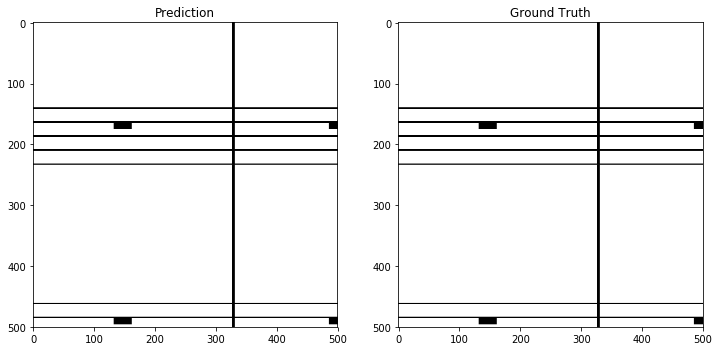

[[333.89617413 261.01779922 361.37655315 284.71553411  31.
   13.        ]]


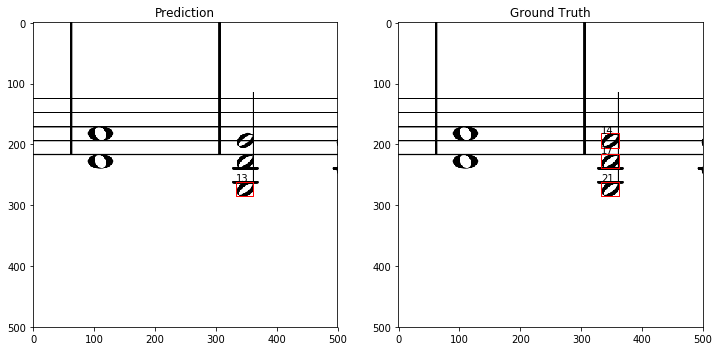

[]


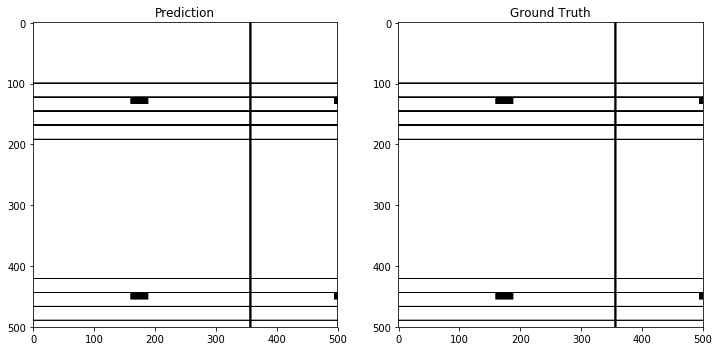

[]


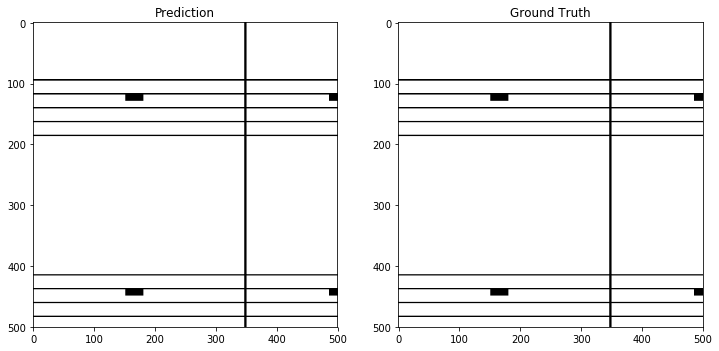

[]


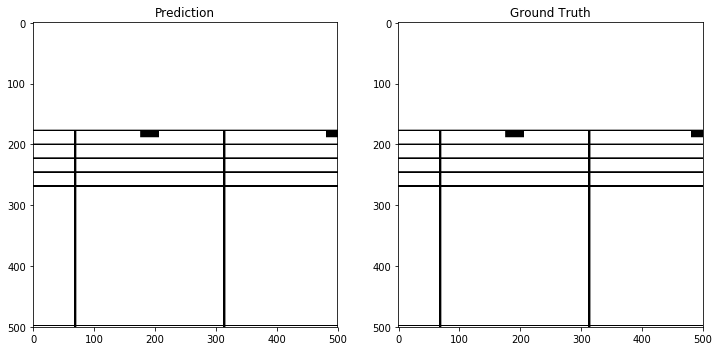

[]


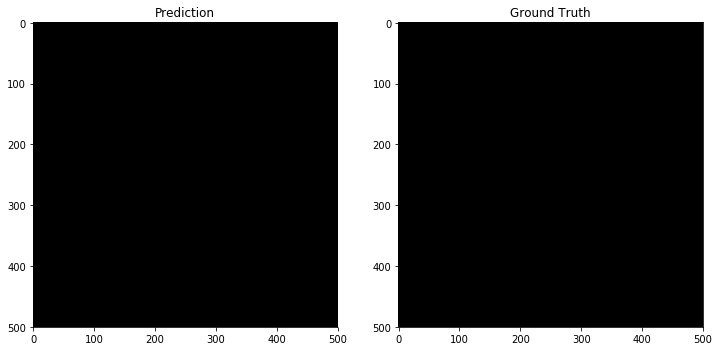

[]


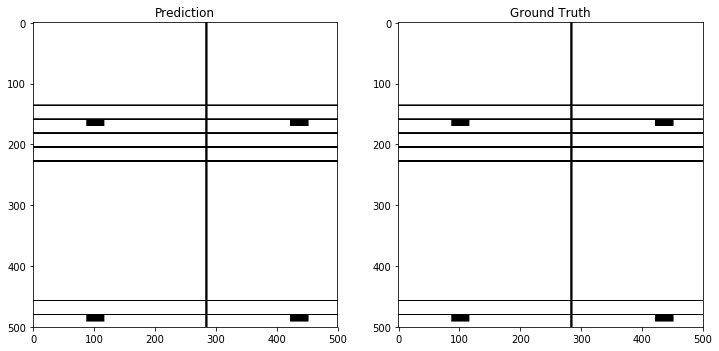

[[ 11.68830788 132.46311888  40.66393093 156.40852291  29.
   13.        ]
 [ 93.33676848 178.06715978 122.10018167 202.02668186  29.
   17.        ]
 [ 93.17037536 130.54091102 122.56662769 158.77407369  29.
   13.        ]
 [175.29949044 132.19483135 204.30284874 157.22037333  29.
   13.        ]
 [175.57259856 212.47501178 204.04788337 236.32016895  29.
   18.        ]
 [280.04940961 125.80069091 306.67297845 164.0918464   29.
   13.        ]
 [278.85064678 177.92885415 308.13138914 202.34060693  29.
   19.        ]
 [380.43111543 178.62387754 408.78250686 201.76621534  31.
   13.        ]]


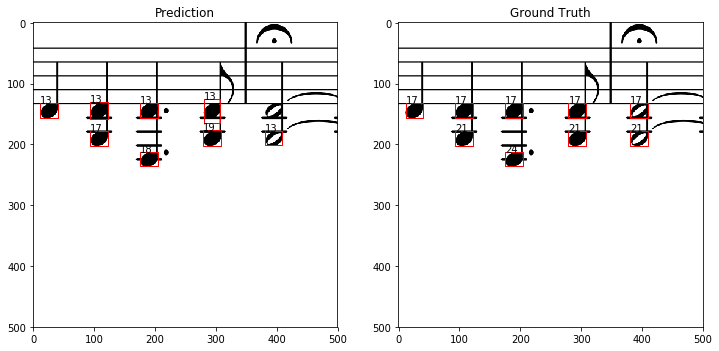

[]


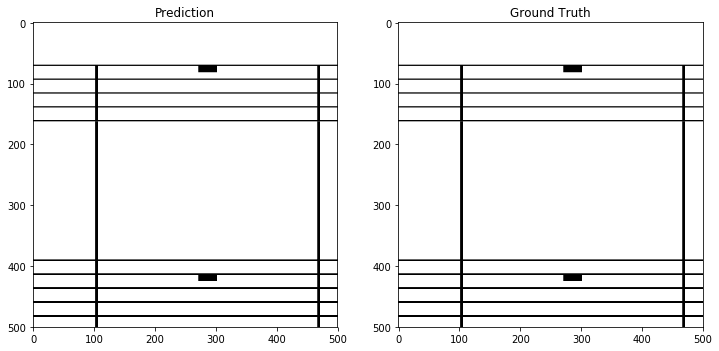

[[314.22994643  -6.71845525 343.25476973  17.20753822  29.
   12.        ]
 [313.70137641 251.74629089 343.28961458 277.6410965   29.
   13.        ]
 [313.83288645 298.39254496 343.16711355 322.60745504  29.
   17.        ]
 [397.1224711    1.21552232 424.07530049  24.43907378  29.
   11.        ]
 [395.50364606 264.24852999 425.37323081 288.79651506  29.
   16.        ]
 [396.24004402 287.05774345 424.73292895 311.28459889  29.
   16.        ]]


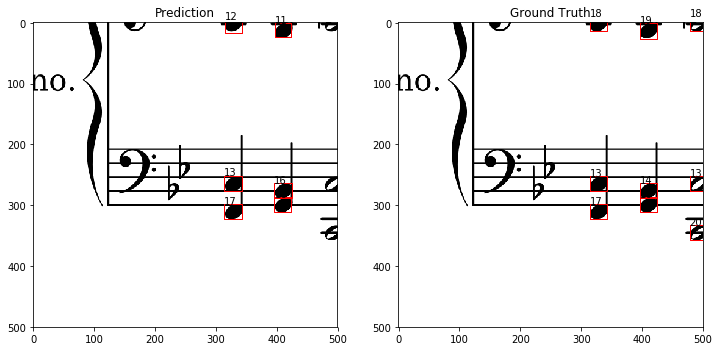

[[174.53015084 311.72806809 202.39884324 336.13583723  31.
   11.        ]
 [292.19292922 254.00607891 321.10647198 279.76637618  29.
   16.        ]
 [292.28815711 323.33185866 321.07574822 347.3219875   29.
   13.        ]
 [372.12097828 277.17882969 401.08143864 301.96920657  29.
   16.        ]
 [372.0490652  311.11480956 401.19869599 336.83742925  29.
   13.        ]
 [372.16269224 357.43965763 401.20572881 381.39659968  29.
   19.        ]]


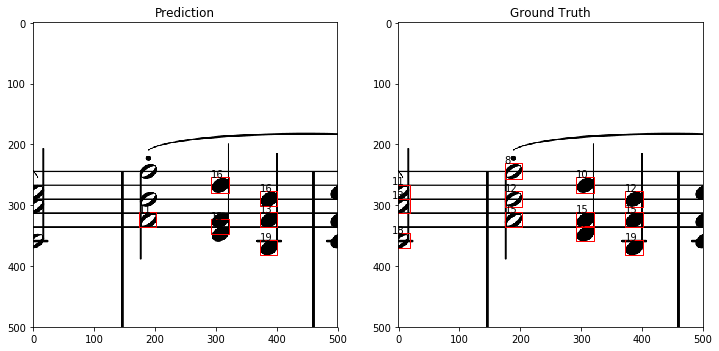

[]


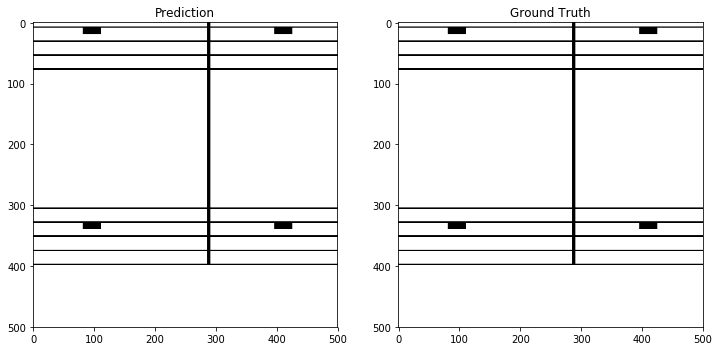

[[  9.95411048  82.50940111  39.54014239 106.8181851   29.
   13.        ]
 [ 10.17061752 104.27083184  39.46522063 130.09911036  29.
   13.        ]
 [ 10.40302071 139.16372802  38.76918473 163.84533542  29.
   16.        ]
 [ 10.21166047 162.31139077  38.76993462 186.56590984  29.
   18.        ]
 [ 10.86172114 470.98892452  39.15572072 494.20293595  29.
   13.        ]
 [115.12841357  84.89795648 141.5301967  126.8240979   29.
   12.        ]
 [113.89412002 161.79973848 143.16063503 186.44233645  29.
   13.        ]
 [114.6087315  466.55623783 142.28082074 498.96018008  29.
   13.        ]
 [214.90052075  93.64404031 244.37332541 117.89442123  31.
   12.        ]
 [215.77334983 162.15768104 244.07703185 186.62399835  31.
   13.        ]
 [215.32854265 470.57512601 244.280153   494.49940815  31.
   11.        ]
 [335.65173303  84.63862311 362.64980543 127.23829997  29.
   16.        ]
 [334.93759176 162.15466343 363.62205478 186.22236161  29.
   11.        ]
 [336.13167472 465.622504

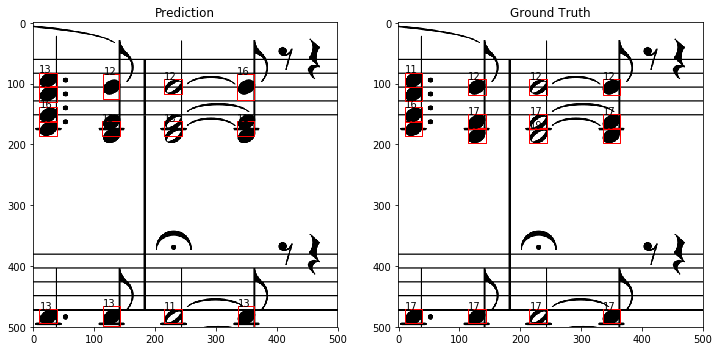

[]


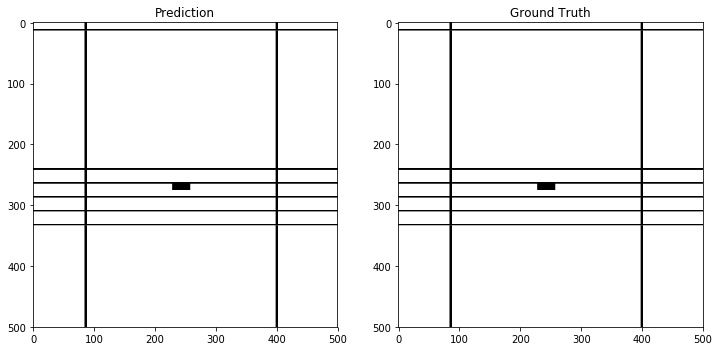

[]


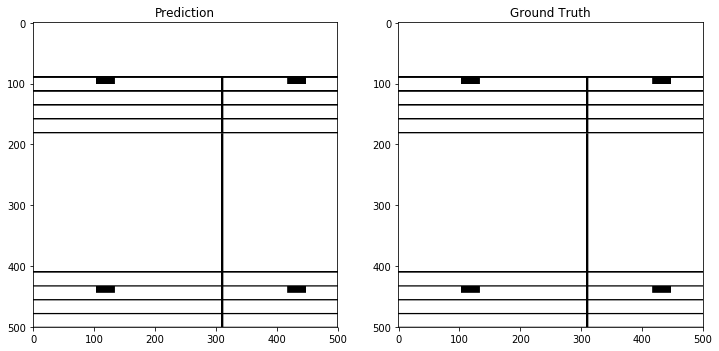

[]


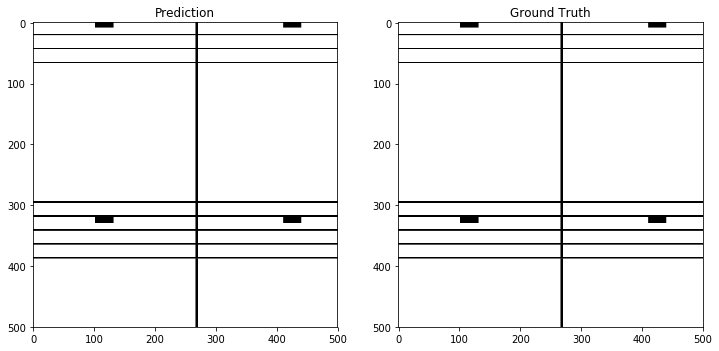

[[204.03823151  13.30412541 232.7250821   37.3112592   29.
   11.        ]
 [285.74197376  24.29604558 314.91465275  48.69793033  29.
   12.        ]
 [368.07908262  13.98035831 396.10109756  36.80042247  29.
   11.        ]
 [471.40125714   3.75008741 499.62028132  46.80991259  29.
    9.        ]]


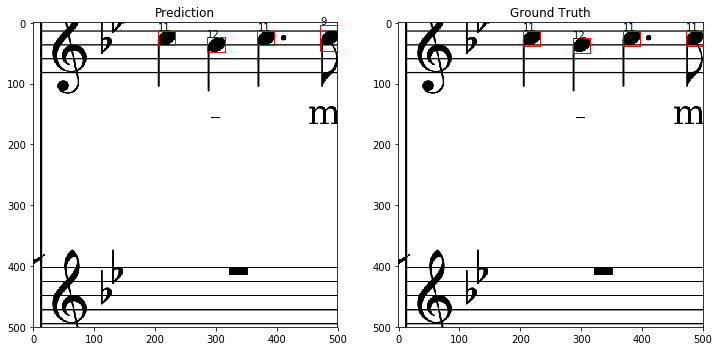

[]


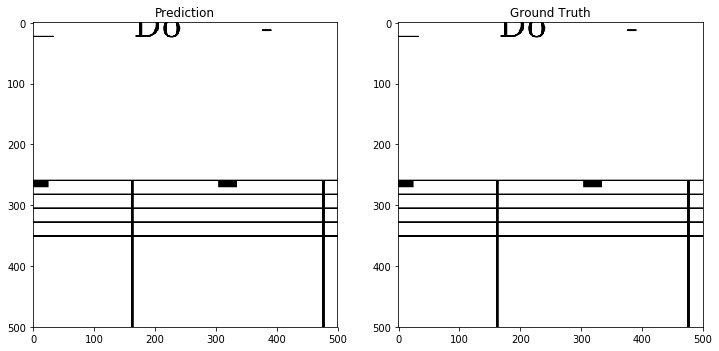

[[ 64.97741177 217.69715625  93.6972151  243.13866465  29.
   12.        ]
 [ 65.28484924 263.82276367  93.51155795 287.87783513  29.
   18.        ]
 [169.3105989  213.29098891 197.05798116 247.45825581  29.
   16.        ]
 [169.24537816 250.5543163  197.49426681 278.85988489  29.
   13.        ]
 [168.59974417 297.95109991 197.88980807 322.55039263  29.
   19.        ]
 [383.84891699 204.67638563 413.78802568 232.85227679  31.
   11.        ]]


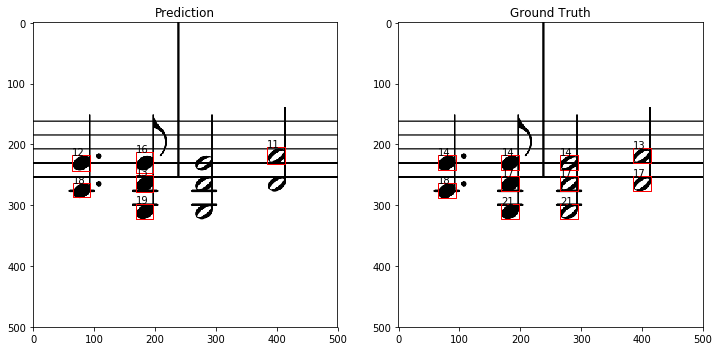

[]


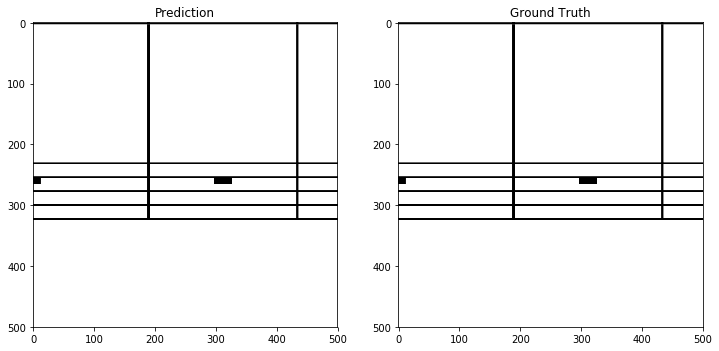

[[225.72474399  71.94002624 255.13411487  96.53444824  29.
   11.        ]
 [307.45453517  83.19978786 337.43637392 107.8547576   29.
   12.        ]
 [389.52786051  72.30454686 418.71310334  95.98460976  29.
   11.        ]]


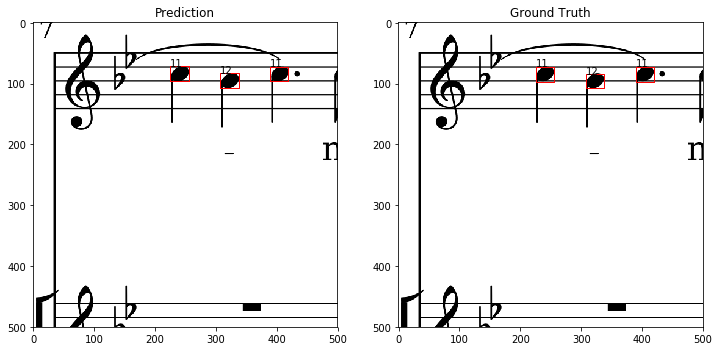

[]


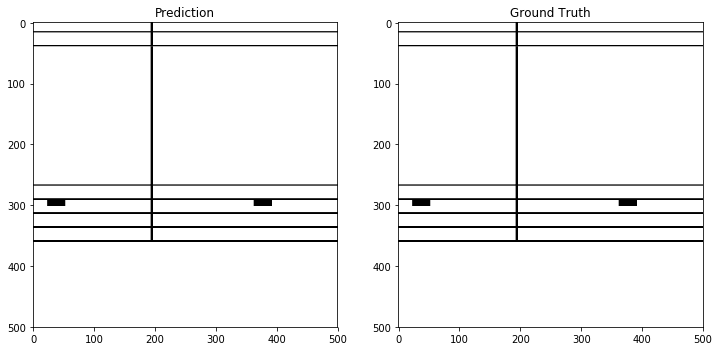

[]


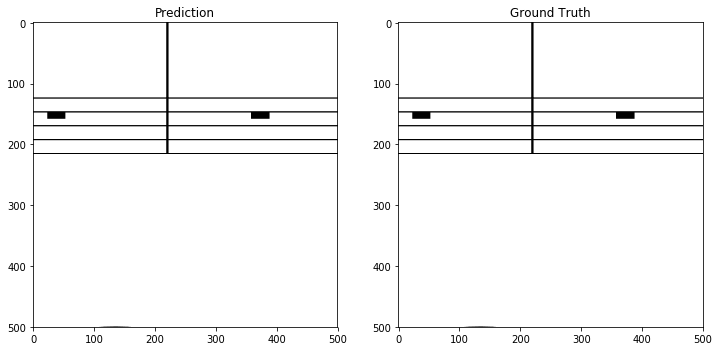

[]


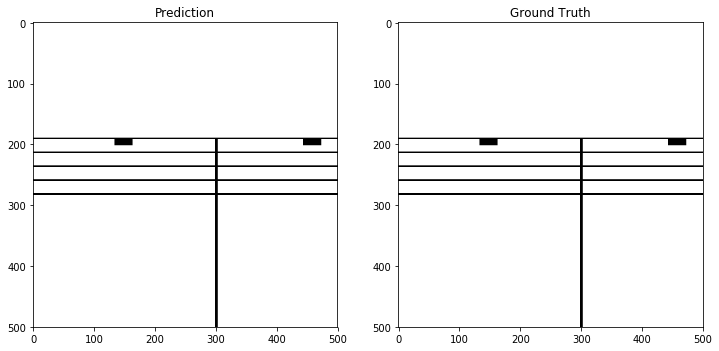

[]


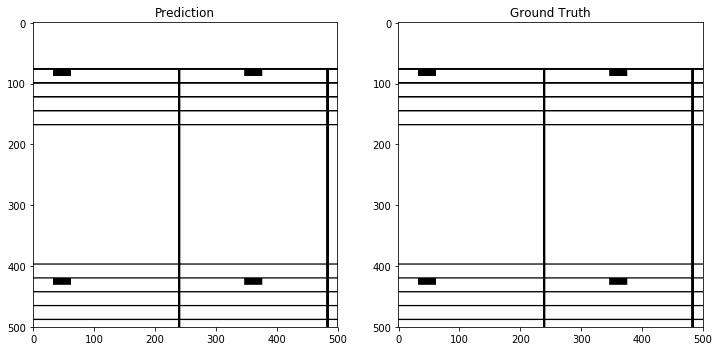

[]


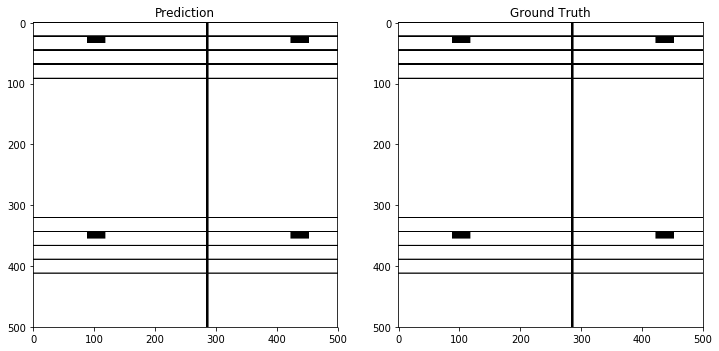

[]


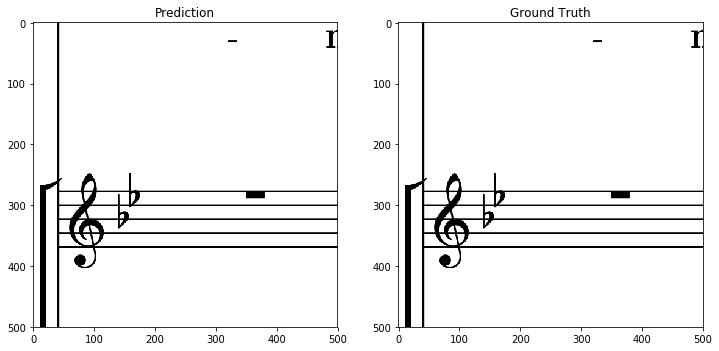

[]


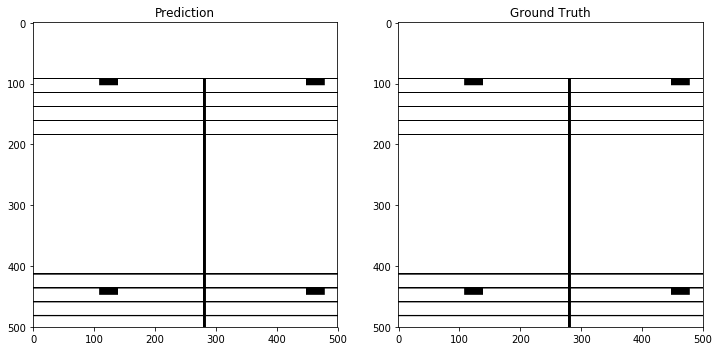

[]


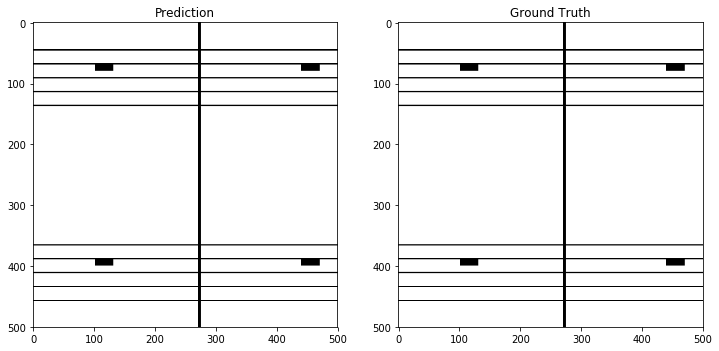

[[  7.02732561 261.51612168  36.41035555 285.69547252  29.
   13.        ]
 [  7.21863145 283.75488553  36.11470189 308.50337273  29.
   13.        ]
 [  6.61713842 317.93034835  36.72010498 343.16642584  29.
    7.        ]
 [  7.75797214 341.50221298  35.93479894 365.2086304   29.
   12.        ]
 [111.87767986 263.41817333 139.01593716 305.77331603  29.
   16.        ]
 [110.8746274  340.80096709 140.27899579 365.26280103  29.
   13.        ]
 [213.1768202  352.74432121 240.7934179  375.76163117  31.
   11.        ]
 [332.416577   264.02793987 360.28067071 305.409369    29.
   16.        ]
 [331.76398143 340.91160862 361.09358098 365.32040313  29.
   11.        ]]


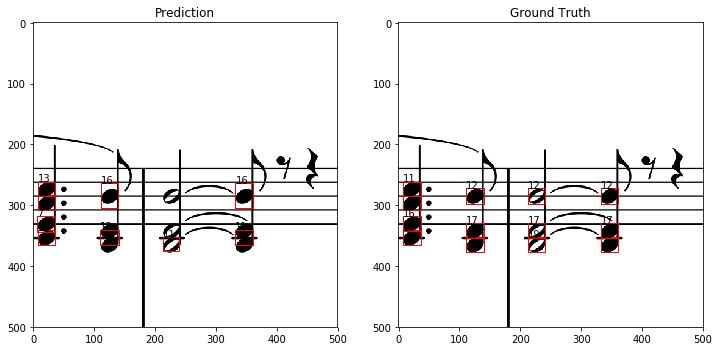

[[ 22.89525275  10.93366755  52.82415023  57.72901902  29.
    9.        ]
 [351.05613658  10.54515168 380.06625148  34.72051997  29.
   12.        ]
 [432.9510109   10.48208015 461.91221098  34.73980435  29.
    7.        ]]


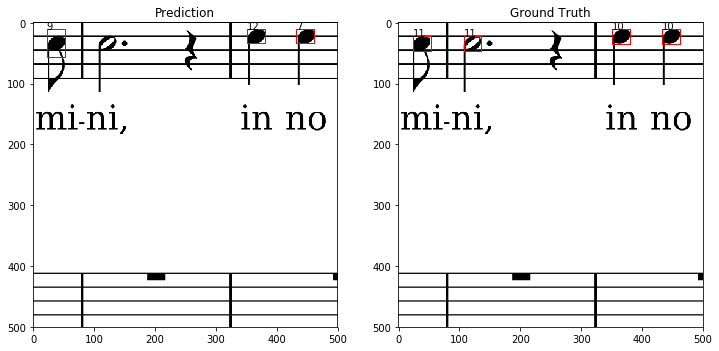

[]


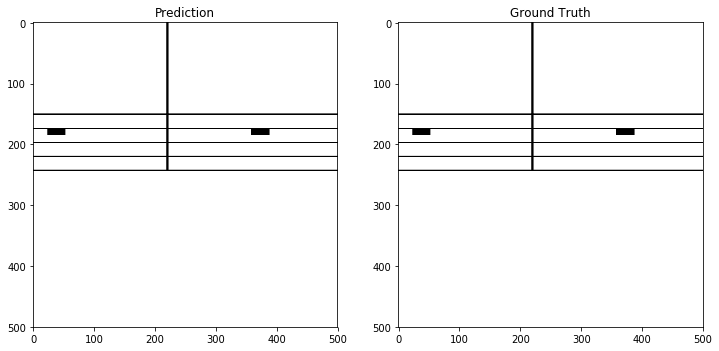

[[ 70.64673239 219.71069232 100.27267059 249.88930768  29.
   13.        ]
 [ 70.80981195 268.27717597 100.35635119 292.6956337   29.
   17.        ]
 [152.70567877 234.13327365 182.09312003 258.63549511  29.
    7.        ]
 [152.71014881 256.93407218 182.04136635 281.42350358  29.
   16.        ]
 [234.5486107  222.66756696 263.34645103 246.90033428  31.
   11.        ]
 [234.21015537 302.79931453 263.73872642 326.36362477  31.
   12.        ]]


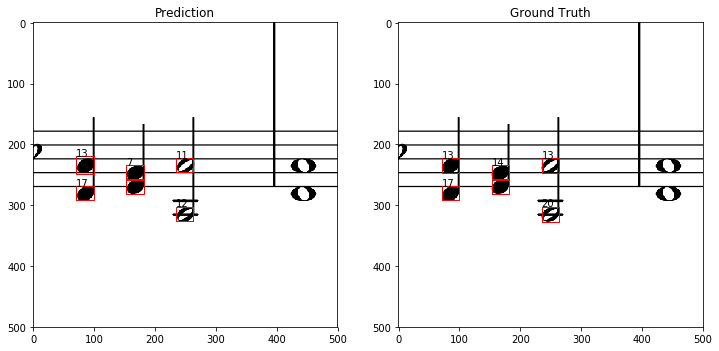

[[ -6.50007749 276.74036494  23.54915725 304.78724242  29.
   12.        ]
 [ -5.69029289 336.14649464  22.61756562 359.39895991  29.
   11.        ]
 [ -5.79856796 358.11500347  23.18180149 382.60355941  29.
   11.        ]
 [ 75.16048214 298.36321482 105.43326786 327.93053518  31.
   12.        ]
 [103.31830256 267.06115388 132.15436625 291.61408728  31.
   11.        ]]


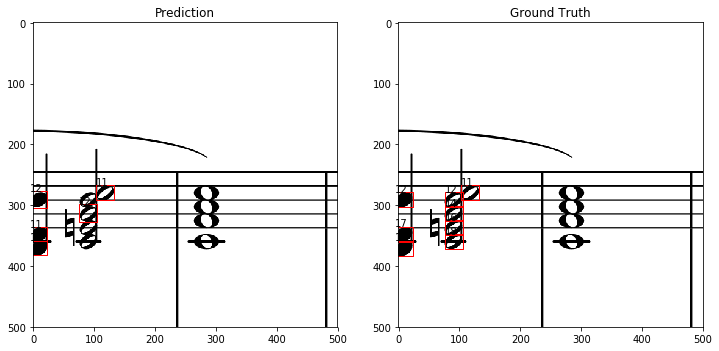

[]


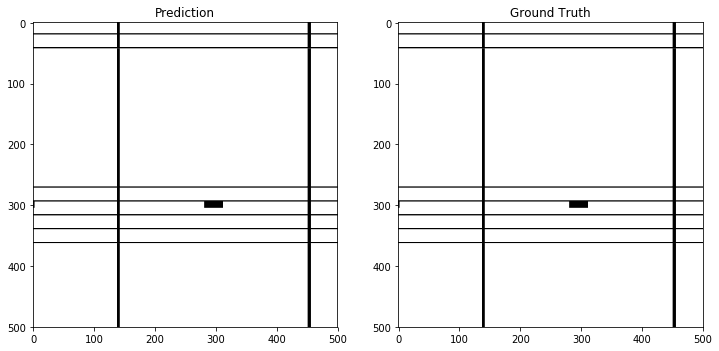

[]


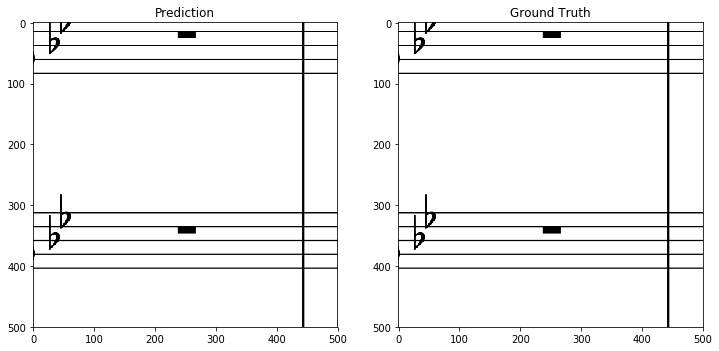

[[ 39.26827735 212.53784821  68.14561993 236.30807324  29.
   13.        ]
 [ 39.23883668 270.06256867  68.02063854 293.40681909  29.
    7.        ]
 [ 39.24331558 292.62454743  67.55179145 316.15221098  29.
   12.        ]
 [143.43864721 211.48820371 171.09386053 260.04740001  29.
   12.        ]
 [142.46081123 280.64722817 171.889043   305.43440448  29.
   13.        ]
 [142.843061   303.23258477 171.85446986 328.22420535  29.
   17.        ]
 [238.8074289  303.8770647  268.45317716 327.57142015  31.
   13.        ]]


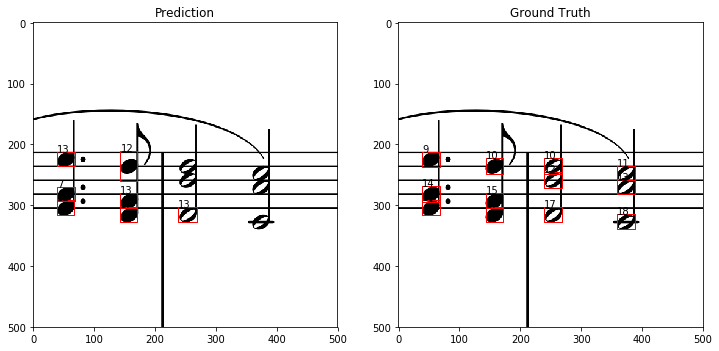

[[ 34.40189427  -2.13435724  63.2943808   22.27762371  29.
   17.        ]
 [229.83113903  20.58546595 259.74461855  45.83271587  29.
   19.        ]
 [312.10112527  55.58032231 341.11444359  79.55141422  29.
   12.        ]
 [416.23020433  21.40482909 444.50473543  45.35420705  29.
   17.        ]]


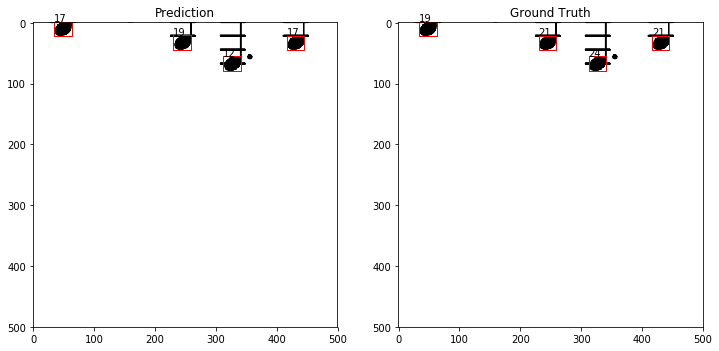

[[109.68222091  41.77021315 138.36046201  68.18100636  31.
   13.        ]
 [109.65553248  88.41922682 138.75440541 112.90375455  31.
   13.        ]
 [412.58691644  53.23700762 442.60702295  79.56905298  29.
    7.        ]
 [412.8406395  134.04909738 442.29708505 158.41796849  29.
   17.        ]]


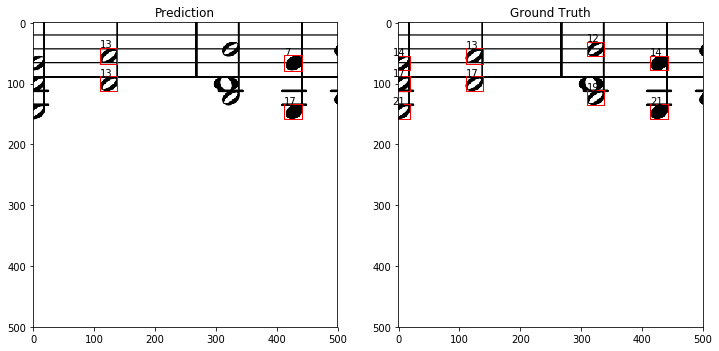

[]


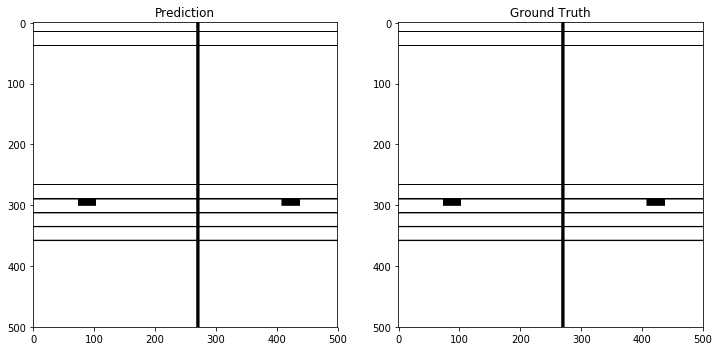

[[ -6.59965754  39.18509922  23.01087249  81.27595997  29.
   11.        ]
 [ 77.25569485  48.18112388 105.91146058  71.96550369  31.
   11.        ]
 [320.72060741  36.14799268 350.33644965  61.23338871  29.
   12.        ]
 [402.82126931  36.36831214 432.1666825   60.86662762  29.
   10.        ]
 [483.88776713  27.94154188 505.75667731  47.28068034  29.
   11.        ]]


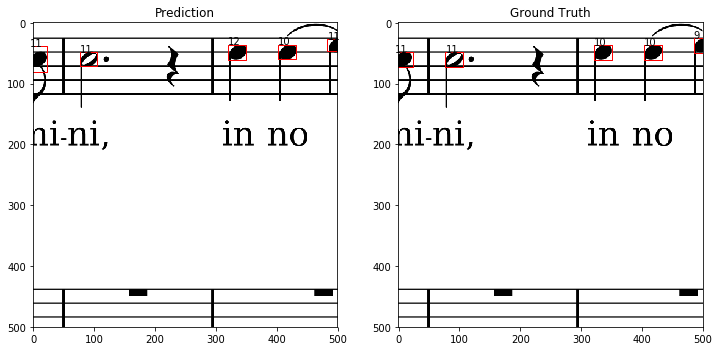

[]


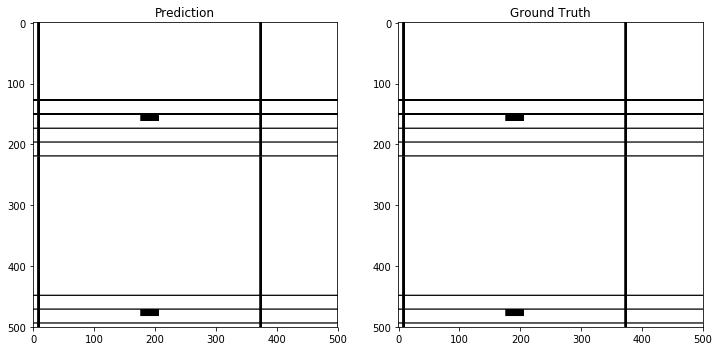

[[ 35.18119722 184.65511785  63.98546945 208.52345358  29.
   12.        ]
 [116.87870877 184.29129189 146.14831826 208.81381321  29.
   12.        ]
 [198.8274011  173.6022068  228.1430131  197.27945001  29.
   11.        ]
 [302.85801206 173.80130302 331.5112187  219.32485083  29.
   12.        ]]


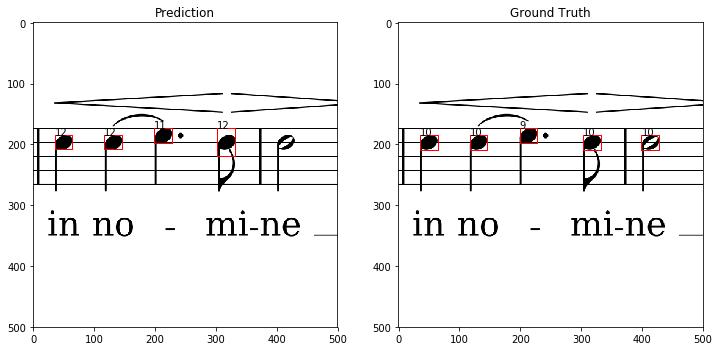

[[100.88610398 429.31426981 129.49779695 454.41947632  31.
   12.        ]
 [286.6348365  418.15907987 314.21689851 442.96394852  31.
   12.        ]
 [286.05461614 452.28304879 315.10687455 477.05856612  31.
   11.        ]
 [403.29283376 395.03940688 433.96098887 420.44683165  29.
   12.        ]
 [403.81407748 452.3906523  433.40253973 477.06335363  29.
   13.        ]
 [404.36664013 476.1787596  433.07942401 500.38683807  29.
   11.        ]
 [481.76379917 454.91002974 506.02519166 475.91565833  29.
   15.        ]
 [482.42744836 419.79152839 506.66346073 441.31007589  29.
   18.        ]]


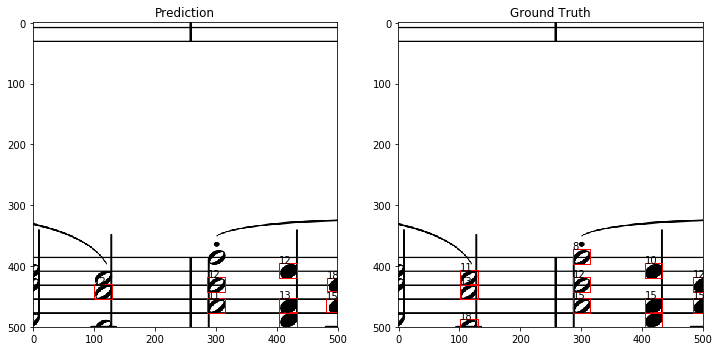

[]


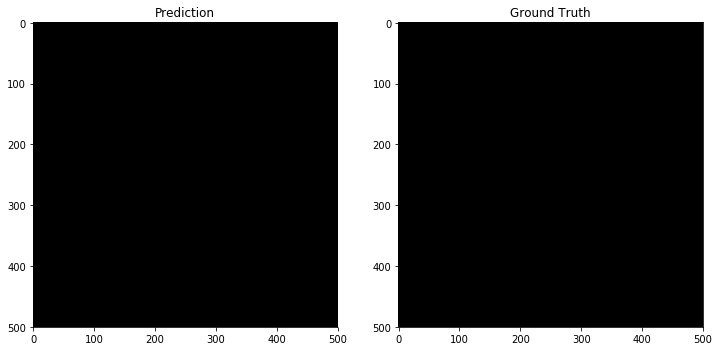

[]


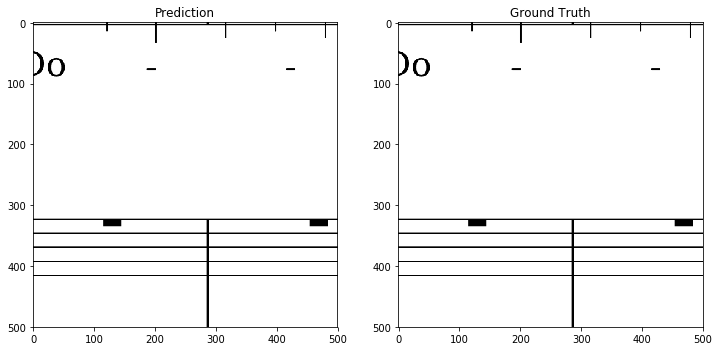

[]


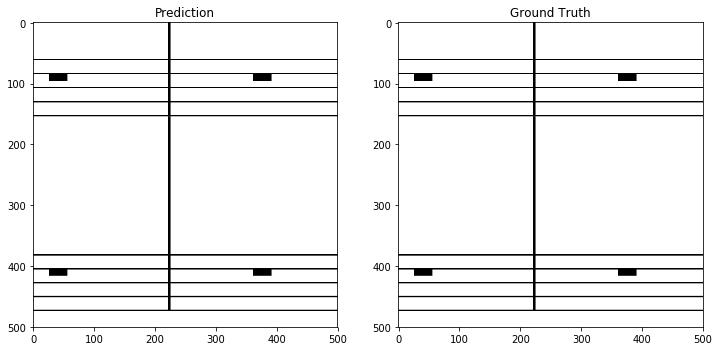

[[ 21.53381576 188.69327169  49.66618424 212.13749754  29.
   13.        ]
 [ 21.05407635 245.68923026  49.82738262 269.44146883  29.
   12.        ]
 [ 21.14602778 268.68403937  49.6260087  292.36155333  29.
   12.        ]
 [125.3982387  189.87987045 153.09717414 233.88159744  29.
   12.        ]
 [124.48673046 256.84995826 154.02055817 281.2433362   29.
   13.        ]
 [125.25827772 280.11114285 153.6836183  303.56469813  29.
   17.        ]
 [221.3441776  279.80384389 250.22591586 303.6042558   31.
   13.        ]]


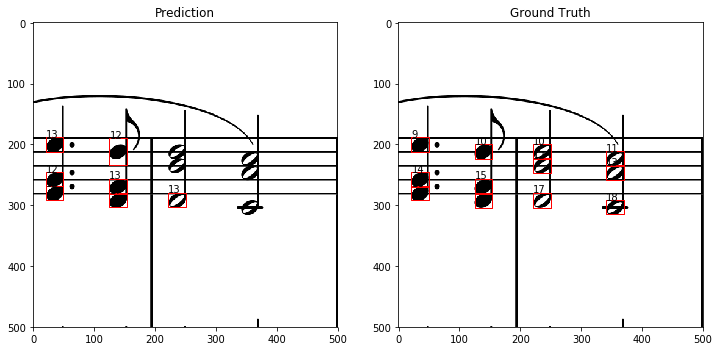

[]


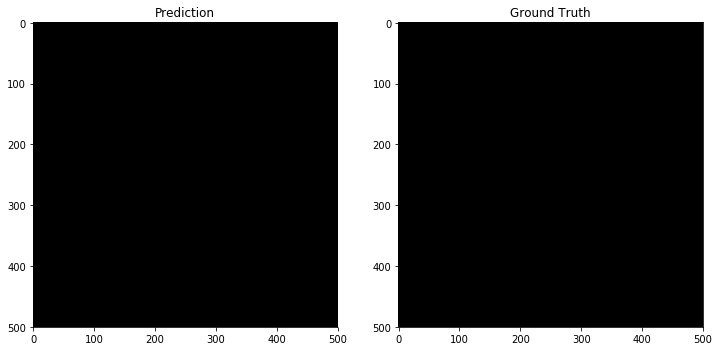

[]


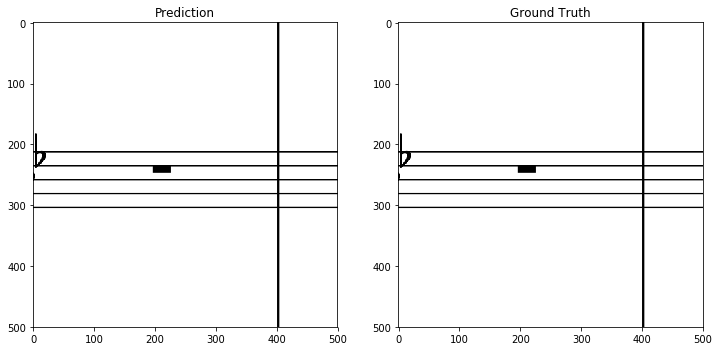

In [127]:
gt_boxes = {}
pred_boxes = {}

for i in range(50):
    X, y = validation_generator[0]
    y_pred = dwd_model.predict(X)
    
    energy_map = np.argmax(y_pred[0], axis=-1)[0]
    energy_map_binarized = 255 * (np.argmax(y_pred[0], axis=-1)[0] < 3) # binarize image
    
    class_prediction_img = np.argmax(y_pred[1], axis=-1)[0]
    bbox_prediction      = y_pred[2][0,:,:,:]
    note_prediction_img  = np.argmax(y_pred[3], axis=-1)[0]
    
    prep = energy_map_binarized
    labels, out_img = find_connected_comp(prep)
    
    n_components = len(np.unique(out_img))
    
    counter = {}
    summation = {}
    center = {}
    class_pred = {}
    bbox = {}
    note = {}
    for label in labels:
        component_id = labels[label]
        if component_id not in counter:
            counter[component_id] = 0
            center[component_id] = (0,0)
            class_pred[component_id] = []
            bbox[component_id] = (0,0)
            note[component_id] = []

        counter[component_id] += 1
        center[component_id] = (center[component_id][0] + label[0], center[component_id][1] + label[1])
        class_pred[component_id].append(class_prediction_img[label[0],label[1]])
        bbox[component_id] = (bbox[component_id][0] + bbox_prediction[label[0],label[1],0], bbox[component_id][1] + bbox_prediction[label[0],label[1],1] )
        note[component_id].append(note_prediction_img[label[0],label[1]])
    
    for center_id in center:
        center[center_id] = (center[center_id][0] / counter[center_id], center[center_id][1] / counter[center_id])
        class_pred[center_id] = max(set(class_pred[center_id]), key = class_pred[center_id].count)
        bbox[center_id] = (bbox[center_id][0] / counter[center_id], bbox[center_id][1] / counter[center_id])
        note[center_id] = max(set(note[center_id]), key=note[center_id].count)
        
    boxes = []
    # filter prediction boxes
    for idx, obj in enumerate(center.keys()):
        boxes.append([center[obj][1] - bbox[obj][1] / 2, center[obj][0] - bbox[obj][0] / 2, 
                      center[obj][1] + bbox[obj][1] / 2, center[obj][0] + bbox[obj][0] / 2, class_pred[obj], note[obj]])

    boxes = filterBoxes(boxes, [29, 31])
    boxes = np.array(boxes)
    print(boxes)
    suppressed_box = non_max_suppression_fast(boxes, 0.25)
    
    # compute confidence values
    scores = []
    for idx in range(len(suppressed_box)):
        center_point_c = int((suppressed_box[idx][0] + suppressed_box[idx][2]) / 2)
        center_point_r = int((suppressed_box[idx][1] + suppressed_box[idx][3]) / 2)
        scores.append(energy_map[center_point_r, center_point_c] / 10)
        
    # filter ground truth boxes
    y['boxes'][0] = filterBoxes(y['boxes'][0], classToFilter=['noteheadHalf', 'noteheadBlack'])
        
    # plot
    img = X[0,:,:,0]
    fig, ax = plt.subplots(1, 2, figsize=(12,12))
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')

    patches = []
    for box in suppressed_box:
        patches.append(Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1]))
        ax[0].text(box[0], box[1], box[5])
        
    pc = PatchCollection(patches, facecolor='None', edgecolor='r')
    ax[0].add_collection(pc)

    patches = []
    for box in y['boxes'][0]:
        patches.append(Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1]))
        midpoint = (box[0] + box[2])//2, (box[1] + box[3])//2
        ax[1].text(box[0], box[1], y['note_map'][0,midpoint[1],midpoint[0],0])
        
    pc = PatchCollection(patches, facecolor='None', edgecolor='r')
    ax[1].add_collection(pc)

    ax[0].set_title('Prediction')
    ax[1].set_title('Ground Truth')

    plt.show()
    
    
    # add to dictionary
    gt_boxes[i] = y['boxes'][0]
    
    pred_boxes[i] = {
        'boxes': suppressed_box,
        'scores': scores,
    }

In [128]:
np.unique(y['note_map'][0])

array([0])

Text(0.5,1,'[0]')

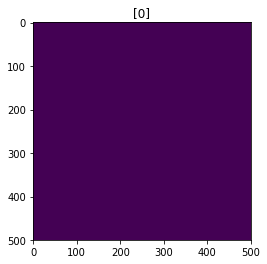

In [129]:
plt.imshow(note_prediction_img == 21)
plt.title(np.unique(note_prediction_img))

Text(0.5,1,'[0]')

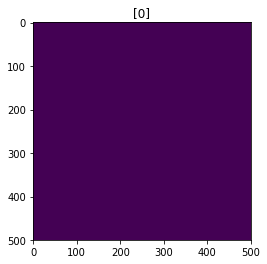

In [130]:
plt.imshow(y['note_map'][0,:,:,0])
plt.title(np.unique(y['note_map'][0,:,:,0]))

In [131]:
print("mAP = ", evaluate(gt_boxes, pred_boxes))

ValueError: too many values to unpack (expected 4)

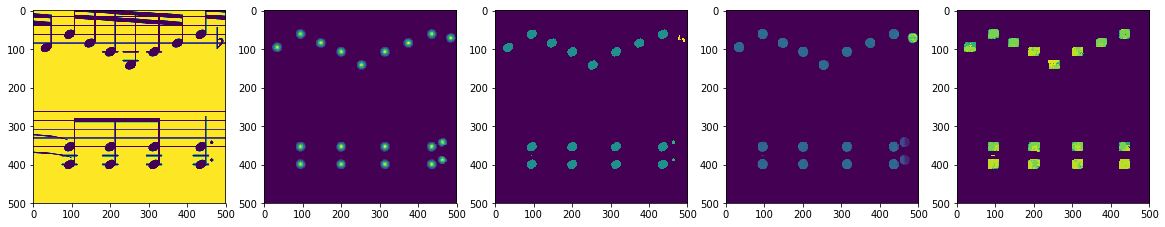

In [138]:
X, y = validation_generator[0]
y_pred = dwd_model.predict(X)
plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.imshow(X[0,:,:,0])
plt.subplot(1,5,2)
plt.imshow(np.argmax(y_pred[0], axis=-1)[0])
plt.subplot(1,5,3)
plt.imshow(np.argmax(y_pred[1], axis=-1)[0])
plt.subplot(1,5,4)
plt.imshow(y_pred[2][0,:,:,0])
plt.subplot(1,5,5)
plt.imshow(np.argmax(y_pred[3], axis=-1)[0])

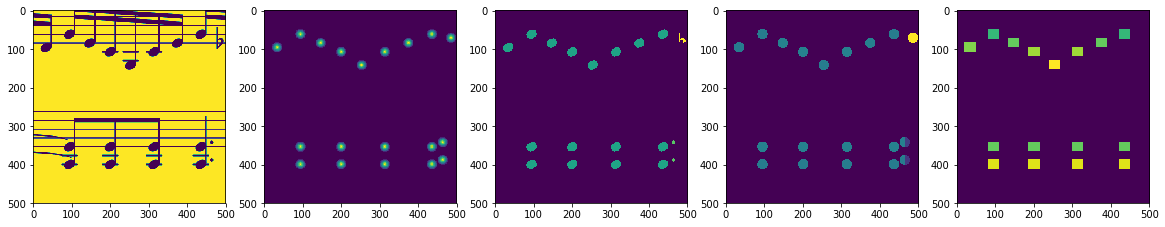

In [152]:
plt.figure(figsize=(20,20))
plt.subplot(1,5,1)
plt.imshow(X[0,:,:,0])
plt.subplot(1,5,2)
plt.imshow(np.max(y['energy_map'][0], axis=-1))
plt.subplot(1,5,3)
plt.imshow(np.max(y['class_map'][0], axis=-1))
plt.subplot(1,5,4)
plt.imshow(y['bbox_map'][0][:,:,0])
plt.subplot(1,5,5)
plt.imshow(np.max(y['note_map'][0], axis=-1))

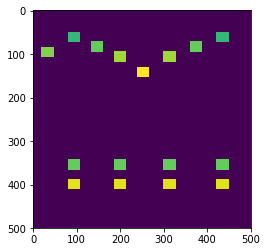

In [148]:
plt.imshow(np.max(y['note_map'][0], axis=-1))

In [ ]:
??filterBoxes

In [ ]:
boxes